# Low dimensional logistic regression label transfer of variance decomposed Single Cell Data

## Author Notes

* The following tutorial describes a method for integrating data by label transfering based on ridge regulariased logistic regression in low-dimensional space. This approach enables us to fit a model on the annotated training/landscape/reference dataset to predict labels of a new dataset and embed these labels onto neighbourhoods in the prediction data. 

* Logistic regression can (1) be used to classify samples, (2) use different types of data (continuous and descrete measurements)and (3) also be used to assess what variables are useful for classifying samples.

#### Current progress: 
- integrating a latent variable model for neighbourhood construction using factor decomposition. 
- Integration of BIC metric
- Integration of Robustness testing
#### Testing required: 
- Robustness of runs need to be tested by permutation of dependent variables and similairty of outcome tested using MI, RAND or BIC

# Author information

### Created on: 291020; Updated: 050621;
### Author: Issac Goh
### Proof readers/Testers: Simone Webb , Mariana Quiroga Londoño, Anthony Rose

In [104]:
import sys
import subprocess

#import pkg_resources
#required = {'harmonypy','sklearn','scanpy','pandas', 'numpy', 'bbknn', 'scipy', 'matplotlib', 'seaborn' ,'scipy'}
#installed = {pkg.key for pkg in pkg_resources.working_set}
#missing = required - installed
#if missing:
#    print("Installing missing packages:" )
#    print(missing)
#    python = sys.executable
#    subprocess.check_call([python, '-m', 'pip', 'install', *missing], stdout=subprocess.DEVNULL)

%matplotlib inline
from collections import Counter
from collections import defaultdict
import scanpy as sc
import pandas as pd
import pickle as pkl
import numpy as np
from bbknn import bbknn
import scipy
import matplotlib.pyplot as plt
import re
import glob
import os
import sys
from geosketch import gs
from numpy import cov
import scipy.cluster.hierarchy as spc
import seaborn as sns; sns.set(color_codes=True)
from sklearn.linear_model import LogisticRegression
import sklearn
import harmonypy as hm
from pathlib import Path

sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=80, color_map='viridis')

# Only block to edit in LR script

In [105]:
# Introduce variables
# Note that this script expects raw data to be in "non-batch-corrected" adata.raw.X. 

# Required: Introduce the path you'd like to save figures or data to 
save_path = "/nfs/team205/ig7/work_backups/backup_210306/projects/YS/YS_090321_notebooks/YS_Reprocess_250721_updates/LR_YS_LIV"

# Required: Name of first object
data1 = "_ys"
# Provide path to obj1 // landscape/training data
Object1 = "/nfs/team205/ig7/work_backups/backup_210306/projects/YS/YS_data/A4_V7_Combined_YS_Fliver_20210914.h5ad"
# Provide categorical to join between datasets
cat1 = "cell.labels"

# Required: Name of second object
data2 = "_fliv"
# Provide path to obj2 // prediction/projection data
Object2 = "/nfs/team205/ig7/work_backups/backup_210306/projects/YS/YS_data/A4_V7_Combined_YS_Fliver_20210914.h5ad"
# Provide categorical to join between datasets
cat2 = "cell.labels"

# Required: LR Model Options
penalty='elasticnet' # can be ["l1","l2","elasticnet"]
#penalty='l2'
sparcity=0.2
max_iter = 200 #Increase if experiencing max iter issues
l1_ratio = 0.5 #If using elasticnet, tis controls the ratio between l1 and l2

# Optional: Batch correction options (this is for correction of eventual combined dataset for data1 and data2)
# If you do not have a batch variable for either data1 or data2, please add a "filler" column in the relevent adata.obs
# for the purposes of batch_correction and batch args below.
# e.g., adata.obs["whatever"] = "something"; batch="whatever"
batch_correction = "Harmony" # Will accept Harmony, BBKNN or False as options
batch = ['tissue_fetal_id','tissue_fetal_id',] # Will accept any batch categorical. Comma space a batch categorical for each dataset. Position 1 is for data1, position 2 is for data2

# Optional: miscellaneous Options.   
subsample_train = False # Samples the training data to the smallest fraction (highly dependent on resolution of input celltype categorical). This corrects for proportional differences between celltype labels of interest in the training data. E.g., training data has 50,000 B cells, 20,000 T cells and 100 HSCs. This function will subsample all training to 100 cells per cell type. 
subsample_prop = False # Give this option a proprtion to subsample to(e.g 0.2), if NA given, will subsample to smallest population
subsample_predict = True
subsample_prop_predict = 0.5
remove_non_high_var = True

train_x = 'X' # Define the resource to train and predict on, PCA, X or UMAP (#if you wish to use gene expression, train_x = 'X')
remove_effect_of_custom_gene_list = 'NA' # "./cell_cycle_genes.csv" #remove a custom list of genes from just the variable genes to compute PCA from. Your .csv should have HGNC gene names in the first column to be read in as a vector, any column name is fine.
use_raw = False # Do you want to use adata.raw.X (recommended)

In [106]:
%%time
# Check if filepaths are good
if not os.path.exists(save_path):
    os.makedirs(save_path)
    
if (Path(Object1).is_file() & Path(Object2).is_file()):
    print("adata file paths detetcted, proceeding to load")
    adata = sc.read(Object1)
    #adata2 =  sc.read(Object2)
    #del adata.uns
    #del adata2.uns
else: 
    raise TypeError("one or more .h5ad paths cannot be accessed")

adata file paths detetcted, proceeding to load
CPU times: user 907 ms, sys: 1.36 s, total: 2.27 s
Wall time: 2.29 s


In [107]:
keep = pd.read_csv('/nfs/team205/ig7/work_backups/backup_210306/projects/YS/resources/intersect_genes.csv',index_col=0)
keep = list(set(list(keep[keep.columns[0]].astype(str))) & set(adata.var.index))
adata = adata[:,keep]
adata

View of AnnData object with n_obs × n_vars = 184203 × 16849
    obs: 'cell.labels', 'stage', 'lanes', 'sex', 'sort.ids', 'fetal.ids', 'component', 'broad_cell.labels', 'sequencing.type', 'orig.dataset', 'broad_cell_labels_organ', 'tissue', 'tissue_fetal_id'
    var: 'n_cells-0', 'mt-0', 'total_counts-0', 'highly_variable-0', 'intersect-0', 'means-0', 'dispersions-0', 'dispersions_norm-0', 'gene.mean-1', 'gene.dispersion-1', 'gene.dispersion.scaled-1', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'cell.labels_colors', 'hvg', 'neighbors', 'pca', 'tissue_colors', 'umap'
    obsm: 'X_pca', 'X_pca_back', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

# Update adata metadata

In [95]:
obs = pd.read_csv('/nfs/team205/ig7/work_backups/backup_210306/projects/YS/YS_090321_notebooks/YS_Reprocess_250721_updates/Combined_YS_Fliver_meta_20210929.csv',index_col=0)
adata.obs = obs

In [96]:
common_cat = "corr_concat" 
adata.obs[common_cat] = "corr_concat"
adata.obs.loc[adata.obs['tissue'].isin(['YS']),common_cat] = adata.obs.loc[adata.obs['tissue'].isin(['YS']),cat1].astype(str) + data1
adata.obs.loc[adata.obs['tissue'].isin(['Liver']),common_cat] = adata.obs.loc[adata.obs['tissue'].isin(['Liver']),cat2].astype(str) + data2

In [58]:
adata.obs

,cell.labels,stage,lanes,sex,sort.ids,fetal.ids,component,broad_cell.labels,sequencing.type,orig.dataset,broad_cell_labels_organ,tissue,tissue_fetal_id
Wang_et_al_AAACCTGAGACCTTTG_1,Sinusoidal_EC,CS10,Wang_CS10,Male,Total,Wang_CS10,Membrane,Endothelium,TBC,Wang_et_al_Cell_Stem Cell_2021,Endothelium_ys,ys,ys_Wang_CS10
Wang_et_al_AAACCTGCACCTATCC_1,MEMP,CS10,Wang_CS10,Male,Total,Wang_CS10,Membrane,Progenitors,TBC,Wang_et_al_Cell_Stem Cell_2021,Progenitors_ys,ys,ys_Wang_CS10
Wang_et_al_AAACCTGCACTTAAGC_1,HSPC_1,CS10,Wang_CS10,Male,Total,Wang_CS10,Membrane,Progenitors,TBC,Wang_et_al_Cell_Stem Cell_2021,Progenitors_ys,ys,ys_Wang_CS10
Wang_et_al_AAACCTGGTAACGACG_1,Erythroid,CS10,Wang_CS10,Male,Total,Wang_CS10,Membrane,Erythroid,TBC,Wang_et_al_Cell_Stem Cell_2021,Erythroid_ys,ys,ys_Wang_CS10
Wang_et_al_AAACCTGGTCAAAGAT_1,Erythroid,CS10,Wang_CS10,Male,Total,Wang_CS10,Membrane,Erythroid,TBC,Wang_et_al_Cell_Stem Cell_2021,Erythroid_ys,ys,ys_Wang_CS10
...,...,...,...,...,...,...,...,...,...,...,...,...,...
F32_Liver_CD45-_FCAImmP7316895_TTTGTCAAGGTGCACA,Early Erythroid,F32,FCAImmP7316895,nan,CD45-,F32,nan,Erythroid,nan,nan,Erythroid_fliv,fliv,fliv_F32
F32_Liver_CD45-_FCAImmP7316895_TTTGTCAAGTACGCCC,Hepatocyte,F32,FCAImmP7316895,nan,CD45-,F32,nan,Hepatocyte,nan,nan,Hepatocyte_fliv,fliv,fliv_F32
F32_Liver_CD45-_FCAImmP7316895_TTTGTCACAAGCGATG,Early Erythroid,F32,FCAImmP7316895,nan,CD45-,F32,nan,Erythroid,nan,nan,Erythroid_fliv,fliv,fliv_F32
F32_Liver_CD45-_FCAImmP7316895_TTTGTCACACTAGTAC,Early Erythroid,F32,FCAImmP7316895,nan,CD45-,F32,nan,Erythroid,nan,nan,Erythroid_fliv,fliv,fliv_F32


In [79]:
# adata = sc.read(Object1)

In [99]:
adata.obs.index = adata.obs.index.str.replace('_45N','_CD45N')
adata.obs.index = adata.obs.index.str.replace('_45P','_CD45P')
obs = adata.obs[adata.obs['tissue'].isin(['YS'])]
obs_ys = pd.read_csv('/nfs/team205/ig7/work_backups/backup_210306/projects/YS/resources/metadata_A4_V8_YS_integrated_data_singlets_normalised_counts_for_MS_plotting_20220328_with_obsp.csv',index_col= 0)
obs[~obs.index.isin(obs_ys.index)]

,cell.labels,stage,lanes,sex,sort.ids,fetal.ids,component,broad_cell.labels,sequencing.type,orig.dataset,broad_cell_labels_organ,tissue,corr_concat
Wang_et_al_ACTTACTTCAATAAGG_1,DC2,CS10,Wang_CS10,Male,Total,Wang_CS10,Membrane,DC,TBC,Wang_et_al_Cell_Stem Cell_2021,DC_ys,YS,DC2_ys
Wang_et_al_AGCTTGACATAGTAAG_1,DC2,CS10,Wang_CS10,Male,Total,Wang_CS10,Membrane,DC,TBC,Wang_et_al_Cell_Stem Cell_2021,DC_ys,YS,DC2_ys
Wang_et_al_CAGCATAAGTACACCT_1,DC2,CS10,Wang_CS10,Male,Total,Wang_CS10,Membrane,DC,TBC,Wang_et_al_Cell_Stem Cell_2021,DC_ys,YS,DC2_ys
Wang_et_al_CCACCTATCACTTCAT_1,DC2,CS10,Wang_CS10,Male,Total,Wang_CS10,Membrane,DC,TBC,Wang_et_al_Cell_Stem Cell_2021,DC_ys,YS,DC2_ys
Wang_et_al_CCACGGACATATGGTC_1,DC2,CS10,Wang_CS10,Male,Total,Wang_CS10,Membrane,DC,TBC,Wang_et_al_Cell_Stem Cell_2021,DC_ys,YS,DC2_ys
...,...,...,...,...,...,...,...,...,...,...,...,...,...
F80_Yolksac_CD45P_FCAImmP8096693_AGAGCTTTCTCATTCA,DC_precursor,CS15,FCAImmP8096693,Male,CD45P,F80,Membrane,DC,5GEX,De_novo,DC_ys,YS,DC_precursor_ys
F80_Yolksac_CD45P_FCAImmP8096693_AGATTGCCATTAACCG,DC_precursor,CS15,FCAImmP8096693,Male,CD45P,F80,Membrane,DC,5GEX,De_novo,DC_ys,YS,DC_precursor_ys
F80_Yolksac_CD45P_FCAImmP8096693_GATCGATCACGAAATA,DC_precursor,CS15,FCAImmP8096693,Male,CD45P,F80,Membrane,DC,5GEX,De_novo,DC_ys,YS,DC_precursor_ys
F80_Yolksac_CD45P_FCAImmP8096693_GGACAGATCAGCTTAG,DC_precursor,CS15,FCAImmP8096693,Male,CD45P,F80,Membrane,DC,5GEX,De_novo,DC_ys,YS,DC_precursor_ys


In [103]:
obs_ys[obs_ys.index.str.contains('AGAGCTTTCTCATTCA')]

,cell.labels,stage,lanes,sex,sort.ids,fetal.ids,component,broad_cell.labels,sequencing.type,orig.dataset,broad_cell_labels_organ,tissue,V6_old_indexes


In [101]:
obs_ys

,cell.labels,stage,lanes,sex,sort.ids,fetal.ids,component,broad_cell.labels,sequencing.type,orig.dataset,broad_cell_labels_organ,tissue,V6_old_indexes
Wang_et_al_AAACCTGAGACCTTTG_1,Sinusoidal_EC,CS10,Wang_CS10,Male,Total,Wang_CS10,Membrane,Endothelium,TBC,Wang_et_al_Cell_Stem Cell_2021,Endothelium_ys,YS,Wang_et_al_AAACCTGAGACCTTTG_1
Wang_et_al_AAACCTGCACCTATCC_1,MEMP,CS10,Wang_CS10,Male,Total,Wang_CS10,Membrane,Progenitors,TBC,Wang_et_al_Cell_Stem Cell_2021,Progenitors_ys,YS,Wang_et_al_AAACCTGCACCTATCC_1
Wang_et_al_AAACCTGCACTTAAGC_1,HSPC_1,CS10,Wang_CS10,Male,Total,Wang_CS10,Membrane,Progenitors,TBC,Wang_et_al_Cell_Stem Cell_2021,Progenitors_ys,YS,Wang_et_al_AAACCTGCACTTAAGC_1
Wang_et_al_AAACCTGGTAACGACG_1,Erythroid,CS10,Wang_CS10,Male,Total,Wang_CS10,Membrane,Erythroid,TBC,Wang_et_al_Cell_Stem Cell_2021,Erythroid_ys,YS,Wang_et_al_AAACCTGGTAACGACG_1
Wang_et_al_AAACCTGGTCAAAGAT_1,Erythroid,CS10,Wang_CS10,Male,Total,Wang_CS10,Membrane,Erythroid,TBC,Wang_et_al_Cell_Stem Cell_2021,Erythroid_ys,YS,Wang_et_al_AAACCTGGTCAAAGAT_1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
F80_Yolksac_CD45NAF_FCAImmP8096696_TTTGGTTCATCCGTGG,Erythroid,CS15,FCAImmP8096696,Male,CD45NAF,F80,Membrane,Erythroid,5GEX,De_novo,Erythroid_ys,YS,F80_Yolksac_CD45NAF_FCAImmP8096696_TTTGGTTCATC...
F80_Yolksac_CD45NAF_FCAImmP8096696_TTTGTCAAGATGCCAG,Immature_EC,CS15,FCAImmP8096696,Male,CD45NAF,F80,Membrane,Endothelium,5GEX,De_novo,Endothelium_ys,YS,F80_Yolksac_CD45NAF_FCAImmP8096696_TTTGTCAAGAT...
F80_Yolksac_CD45NAF_FCAImmP8096696_TTTGTCAGTCGAACAG,Immature_EC,CS15,FCAImmP8096696,Male,CD45NAF,F80,Membrane,Endothelium,5GEX,De_novo,Endothelium_ys,YS,F80_Yolksac_CD45NAF_FCAImmP8096696_TTTGTCAGTCG...
F80_Yolksac_CD45NAF_FCAImmP8096696_TTTGTCATCATTCACT,Erythroid,CS15,FCAImmP8096696,Male,CD45NAF,F80,Membrane,Erythroid,5GEX,De_novo,Erythroid_ys,YS,F80_Yolksac_CD45NAF_FCAImmP8096696_TTTGTCATCAT...


In [76]:
obs_ys[~obs_ys.index.isin(obs.index)]

,cell.labels,stage,lanes,sex,sort.ids,fetal.ids,component,broad_cell.labels,sequencing.type,orig.dataset,broad_cell_labels_organ,tissue,V6_old_indexes
F61_Yolksac_CD45P_FCAImmP7862088_AAACCTGAGCGTGAAC,Macrophage,CS18,FCAImmP7862088,Male,CD45P,F61,Membrane,Macrophage,5GEX,De_novo,Macrophage_ys,YS,F61_Yolksac_CD45P_FCAImmP7862088_AAACCTGAGCGTGAAC
F61_Yolksac_CD45P_FCAImmP7862088_AAACCTGAGTGAAGAG,Macrophage,CS18,FCAImmP7862088,Male,CD45P,F61,Membrane,Macrophage,5GEX,De_novo,Macrophage_ys,YS,F61_Yolksac_CD45P_FCAImmP7862088_AAACCTGAGTGAAGAG
F61_Yolksac_CD45P_FCAImmP7862088_AAACCTGCACTGTCGG,Macrophage,CS18,FCAImmP7862088,Male,CD45P,F61,Membrane,Macrophage,5GEX,De_novo,Macrophage_ys,YS,F61_Yolksac_CD45P_FCAImmP7862088_AAACCTGCACTGTCGG
F61_Yolksac_CD45P_FCAImmP7862088_AAACCTGCACTTGGAT,Macrophage,CS18,FCAImmP7862088,Male,CD45P,F61,Membrane,Macrophage,5GEX,De_novo,Macrophage_ys,YS,F61_Yolksac_CD45P_FCAImmP7862088_AAACCTGCACTTGGAT
F61_Yolksac_CD45P_FCAImmP7862088_AAACCTGCAGTGGAGT,Macrophage,CS18,FCAImmP7862088,Male,CD45P,F61,Membrane,Macrophage,5GEX,De_novo,Macrophage_ys,YS,F61_Yolksac_CD45P_FCAImmP7862088_AAACCTGCAGTGGAGT
...,...,...,...,...,...,...,...,...,...,...,...,...,...
F79_Yolksac_CD45N_FCAImmP8102304_TTTGTCAGTAATTGGA,Erythroid,CS18,FCAImmP8102304,Male,CD45N,F79,VA,Erythroid,5GEX,De_novo,Erythroid_ys,YS,F79_Yolksac_CD45N_FCAImmP8102304_TTTGTCAGTAATTGGA
F79_Yolksac_CD45N_FCAImmP8102304_TTTGTCAGTAGCGTCC,Erythroid,CS18,FCAImmP8102304,Male,CD45N,F79,VA,Erythroid,5GEX,De_novo,Erythroid_ys,YS,F79_Yolksac_CD45N_FCAImmP8102304_TTTGTCAGTAGCGTCC
F79_Yolksac_CD45N_FCAImmP8102304_TTTGTCAGTAGGGACT,Erythroid,CS18,FCAImmP8102304,Male,CD45N,F79,VA,Erythroid,5GEX,De_novo,Erythroid_ys,YS,F79_Yolksac_CD45N_FCAImmP8102304_TTTGTCAGTAGGGACT
F79_Yolksac_CD45N_FCAImmP8102304_TTTGTCAGTCCTGCTT,Erythroid,CS18,FCAImmP8102304,Male,CD45N,F79,VA,Erythroid,5GEX,De_novo,Erythroid_ys,YS,F79_Yolksac_CD45N_FCAImmP8102304_TTTGTCAGTCCTGCTT


# updated mono calls

In [9]:
mono = pd.read_csv('/nfs/team205/ig7/work_backups/backup_210306/projects/YS/YS_310122_notebooks/fig3_Macrophages/mono_hetero/Mono_hetero_cell_calls.csv',index_col =0)

In [10]:
adata.obs[adata.obs.index.isin(mono.index)]

,cell.labels,stage,lanes,sex,sort.ids,fetal.ids,component,broad_cell.labels,sequencing.type,orig.dataset,broad_cell_labels_organ,tissue,corr_concat
Wang_et_al_ATCATCTAGCGTTGCC_1,Monocyte,CS10,Wang_CS10,Male,Total,Wang_CS10,Membrane,Monocyte,TBC,Wang_et_al_Cell_Stem Cell_2021,Monocyte_ys,YS,Monocyte_ys
Wang_et_al_CACATAGCACGCTTTC_1,Monocyte,CS10,Wang_CS10,Male,Total,Wang_CS10,Membrane,Monocyte,TBC,Wang_et_al_Cell_Stem Cell_2021,Monocyte_ys,YS,Monocyte_ys
Wang_et_al_CCGTACTCATTCCTCG_1,Monocyte,CS10,Wang_CS10,Male,Total,Wang_CS10,Membrane,Monocyte,TBC,Wang_et_al_Cell_Stem Cell_2021,Monocyte_ys,YS,Monocyte_ys
Wang_et_al_GCTGGGTGTGTGACCC_2,Monocyte,CS11,Wang_CS11,Female,Total,Wang_CS11,Membrane,Monocyte,TBC,Wang_et_al_Cell_Stem Cell_2021,Monocyte_ys,YS,Monocyte_ys
Wang_et_al_TGATTTCCATGCGCAC_2,Monocyte,CS11,Wang_CS11,Female,Total,Wang_CS11,Membrane,Monocyte,TBC,Wang_et_al_Cell_Stem Cell_2021,Monocyte_ys,YS,Monocyte_ys
...,...,...,...,...,...,...,...,...,...,...,...,...,...
F32_Liver_CD45+_FCAImmP7316894_TTGACTTTCCGCATCT,Monocyte,F32,FCAImmP7316894,NaN,CD45+,F32,NaN,Monocyte,NaN,NaN,Monocyte_fliv,Liver,Monocyte_fliv
F32_Liver_CD45+_FCAImmP7316894_TTGGCAAAGCAGGTCA,Monocyte,F32,FCAImmP7316894,NaN,CD45+,F32,NaN,Monocyte,NaN,NaN,Monocyte_fliv,Liver,Monocyte_fliv
F32_Liver_CD45+_FCAImmP7316894_TTGTAGGGTCCAGTAT,Monocyte,F32,FCAImmP7316894,NaN,CD45+,F32,NaN,Monocyte,NaN,NaN,Monocyte_fliv,Liver,Monocyte_fliv
F32_Liver_CD45+_FCAImmP7316894_TTTGCGCAGAGGTACC,Monocyte,F32,FCAImmP7316894,NaN,CD45+,F32,NaN,Monocyte,NaN,NaN,Monocyte_fliv,Liver,Monocyte_fliv


In [11]:
adata.obs['corr_concat'] = adata.obs['corr_concat'].astype(str)
adata.obs.loc[adata.obs.index.isin(mono.index),'corr_concat']= mono['corr_concat']

# Mod both data manually

In [12]:
adata.obs.columns

Index(['cell.labels', 'stage', 'lanes', 'sex', 'sort.ids', 'fetal.ids',
       'component', 'broad_cell.labels', 'sequencing.type', 'orig.dataset',
       'broad_cell_labels_organ', 'tissue', 'corr_concat'],
      dtype='object')

In [13]:
adata.obs["lr_batch"]  = adata.obs["tissue"].astype(str) + '_' +  adata.obs['fetal.ids'].astype(str)

In [14]:
adata.obs['corr_concat'] = adata.obs['corr_concat'].astype(str)
adata.obs[common_cat] = adata.obs[common_cat].str.replace('Monocyte_0','Monocyte_0_ys')
adata.obs[common_cat] = adata.obs[common_cat].str.replace('Monocyte_ys_1','Monocyte_1_ys')


# Get a subset made first

In [15]:
list(adata.obs[common_cat].unique())

['Sinusoidal_EC_ys',
 'MEMP_ys',
 'HSPC_1_ys',
 'Erythroid_ys',
 'Endoderm_ys',
 'Immature_EC_ys',
 'Macrophage_ys',
 'MK_ys',
 'Early_Erythroid_ys',
 'Lymphoid_progenitor_ys',
 'Mesothelium_ys',
 'Prolif_Sinusoidal_EC_ys',
 'Fibroblast_ys',
 'HSPC_2_ys',
 'AEC_ys',
 'Mast_cell_ys',
 'MOP_ys',
 'DC2_ys',
 'CMP_ys',
 'DC_precursor_ys',
 'HE_ys',
 'Monocyte_0_ys',
 'Monocyte_1_ys',
 'LMPP_ys',
 'Neutrophil_precursor_ys',
 'Microglia_ys',
 'Smooth_Muscle_ys',
 'Promonocyte_ys',
 'Eo_Baso_Mast_precursor_ys',
 'ILC_precursor_ys',
 'Pre_Macrophage_ys',
 'VWF_EC_ys',
 'Eo_Basophil_ys',
 'Prolif_AEC_ys',
 'NK_ys',
 'Monocyte_Macrophage_ys',
 'MPP_fliv',
 'Kupffer_cell_1_fliv',
 'Kupffer_cell_2_fliv',
 'Hepatocyte_fliv',
 'Endothelium_fliv',
 'Early_Erythroid_fliv',
 'MEMP_fliv',
 'MLP_fliv',
 'MK_fliv',
 'Erythroid_fliv',
 'DC3_fliv',
 'DC2_fliv',
 'Monocyte_fliv',
 'HSC_fliv',
 'Promyelocyte_fliv',
 'Mast_cell_fliv',
 'DC1_fliv',
 'CMP_fliv',
 'Pre_pro_B_progenitor_fliv',
 'Embryonic_Erythroi

# Below modules will be tuned into functions in package

## Combining data and Preprocess

In [16]:
%%time
# Check if filepaths are good
if not os.path.exists(save_path):
    os.makedirs(save_path)
    

# altering scanpy setting so that we can save it to our defined directory
sc._settings.ScanpyConfig(figdir=save_path)

# Combine and pre-process data to match correlations across PCA

# Module to detect shape mismatch and alternatively rebuild adata
#if(use_raw==True):
#    print('option detected to use raw data, proceeding to check if raw exists and if it matches data.X')
#    if (hasattr(adata.raw, "X")):
#        try: adata.X =  adata.raw.X  ; print('no mismatch in shape for adata detected')
#        except: print("adata.X shape mismatched with adata.raw.X, proceeding to re-build data") ; adata = adata.raw.to_adata()
#    else:
#        print("no raw data detected in adata! proceeding to create raw partition from adata.X")
#        adata.raw = adata
#        
#    if (hasattr(adata2.raw, "X")):
#        try: adata2.X = adata2.raw.X ; print('no mismatch in shape for adata2 detected')
#        except: print("adata2.X shape mismatched with adata.raw.X, proceeding to re-build data") ; adata2 = adata2.raw.to_adata()
#    else:
#        print("no raw data detected in adata! proceeding to create raw partition from adata.X")
#        adata2.raw = adata2
#            
## Define intersecting genes between datasets
#adata_genes = list(adata.var.index)
#adata2_genes = list(adata2.var.index)
#keep_SC_genes = list(set(adata_genes) & set(adata2_genes))
#print("keep gene list = " , len(keep_SC_genes), "adata1 gene length = ", len(adata_genes) , "adata2 gene length = ", len(adata2_genes) )###

# Remove non-intersecting genes (this step will remove cite-seq data if training data is pure RNA seq)
#adata_intersect1 = adata[:, keep_SC_genes]
#adata = adata_intersect1
#adata_intersect2 = adata2[:, keep_SC_genes]
#adata2 = adata_intersect2

# Optional subsampling of training data to 
#if(subsample_train == True):
    
#    if not(subsample_prop=="NA"):
#        print("option to subsample by proportion chosen")
#        prop = subsample_prop
#        data = adata.obs[:]
#        grouped = data.groupby(cat1)
#        df = grouped.apply(lambda x: x.sample(frac=prop))
#        df = df.droplevel(cat1)
#        keep = df.index
#        adata = adata[adata.obs.index.isin(keep)]
#    else:
#        print("subsample by smallest population")
#        data = adata.obs
#        data = data.sample(frac=1).groupby(cat1).head(min(adata.obs.groupby(cat1).size()))
#        keep = data.index
#        adata = adata[adata.obs.index.isin(keep)]
#        
## Optional subsampling of training data to 
#if(subsample_predict == True):
#    if not(subsample_prop_predict=="NA"):
#        print("option to subsample by proportion chosen")
#        prop = subsample_prop_predict
#        data = adata2.obs[:]
#        grouped = data.groupby(cat2)
#        df = grouped.apply(lambda x: x.sample(frac=prop))
#        df = df.droplevel(cat2)
#        keep = df.index
#        adata2 = adata2[adata2.obs.index.isin(keep)]
#    else:
#        print("subsample by smallest population")
#        data = adata2.obs
#        data = data.sample(frac=1).groupby(cat2).head(min(adata.obs.groupby(cat2).size()))
#        keep = data.index
#        adata2 = adata2[adata2.obs.index.isin(keep)]#

# Create a common batch column and do simple sanity check for batch variables
#if not((batch_correction == "False") and (len(batch)>1)):
#    print("Batch correction option detected, proceeding to format batch variables")
#    batch_var = "lr_batch"
#    adata.obs["lr_batch"] = adata.obs[batch[0]]
#    adata2.obs["lr_batch"] = adata2.obs[batch[1]]
#else: raise TypeError("Batch correction option detected but requires at least one categorical for each dataset!")

# Create a common obs column in both datasets containing the data origin tag
#common_cat = "corr_concat" 
#adata.obs[common_cat] = adata.obs[cat1].astype(str) + data1
#adata2.obs[common_cat] = adata2.obs[cat2].astype(str) + data2
#adata.obs = adata.obs.astype('category')
#adata2.obs = adata2.obs.astype('category')
#concat = adata2.concatenate(adata, join='inner',index_unique=None, batch_categories=None)
#adata = concat[:]
#sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
#sc.pp.log1p(adata)
#sc.pp.highly_variable_genes(adata, min_mean=0.1, max_mean=4)
#sc.pp.scale(adata, zero_center=False, max_value=None, copy=False) #zero_center=True (densifies output)

# Optionally remove genes of known confounding effect from variable list
#if not (Path(remove_effect_of_custom_gene_list).is_file()):
#    print("Custom gene list option is not selected or path is not readbale, proceeding with no variable removal")
#else: 
#    print("Custom gene removal list detected, proceeding to remove intersect from variable genes")
#    regress_list = pd.read_csv(remove_effect_of_custom_gene_list)
#    regress_list = regress_list.iloc[:, 0]
#    adata.var["highly_variable"][adata.var.index.isin(regress_list)] = "False"

#Optionally remove genes that do not contribute to variance in combined data::Use only if training and predicting withsim reduced data    
#if(remove_non_high_var==True):
#    high_var = list(adata.var["highly_variable"][adata.var["highly_variable"]==True])
#    adata = adata[:, adata.var["highly_variable"].isin(high_var)]   

# Now compute PCA
#sc.pp.pca(adata, n_comps=50, use_highly_variable=True, svd_solver='arpack')

# Batch correction options
# The script will test later which Harmony values we should use
#if not(batch_correction == "False"):
#    sc.pp.neighbors(adata, n_neighbors=15, n_pcs=50)    
#if(batch_correction == "Harmony"):
#    print("Commencing harmony")
#    # Create hm subset
#    adata_hm = adata[:]
#    # Set harmony variables
#    data_mat = np.array(adata_hm.obsm["X_pca"])
#    meta_data = adata_hm.obs
#    vars_use = [batch_var]
#    # Run Harmony
#    ho = hm.run_harmony(data_mat, meta_data, vars_use)
#    res = (pd.DataFrame(ho.Z_corr)).T
#    res.columns = ['X{}'.format(i + 1) for i in range(res.shape[1])]
#    # Insert coordinates back into object
#    adata_hm.obsm["X_pca_back"]= adata_hm.obsm["X_pca"][:]
#    adata_hm.obsm["X_pca"] = np.array(res)
#    # Run neighbours
#    sc.pp.neighbors(adata_hm, n_neighbors=15, n_pcs=50)
#    adata = adata_hm[:]
#    del adata_hm
#elif(batch_correction == "BBKNN"):
#    print("Commencing BBKNN")
#    sc.external.pp.bbknn(adata, batch_key=batch_var, approx=True, metric='angular', copy=False, n_pcs=50, trim=None, n_trees=10, use_faiss=True, set_op_mix_ratio=1.0, local_connectivity=15) 
    
print("adata1 and adata2 are now combined and preprocessed in 'adata' obj - success!")

adata1 and adata2 are now combined and preprocessed in 'adata' obj - success!
CPU times: user 547 µs, sys: 169 µs, total: 716 µs
Wall time: 1.73 ms


/home/jovyan/my-conda-envs/workhorse/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'cell.labels' as categorical
/home/jovyan/my-conda-envs/workhorse/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'stage' as categorical
/home/jovyan/my-conda-envs/workhorse/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and 

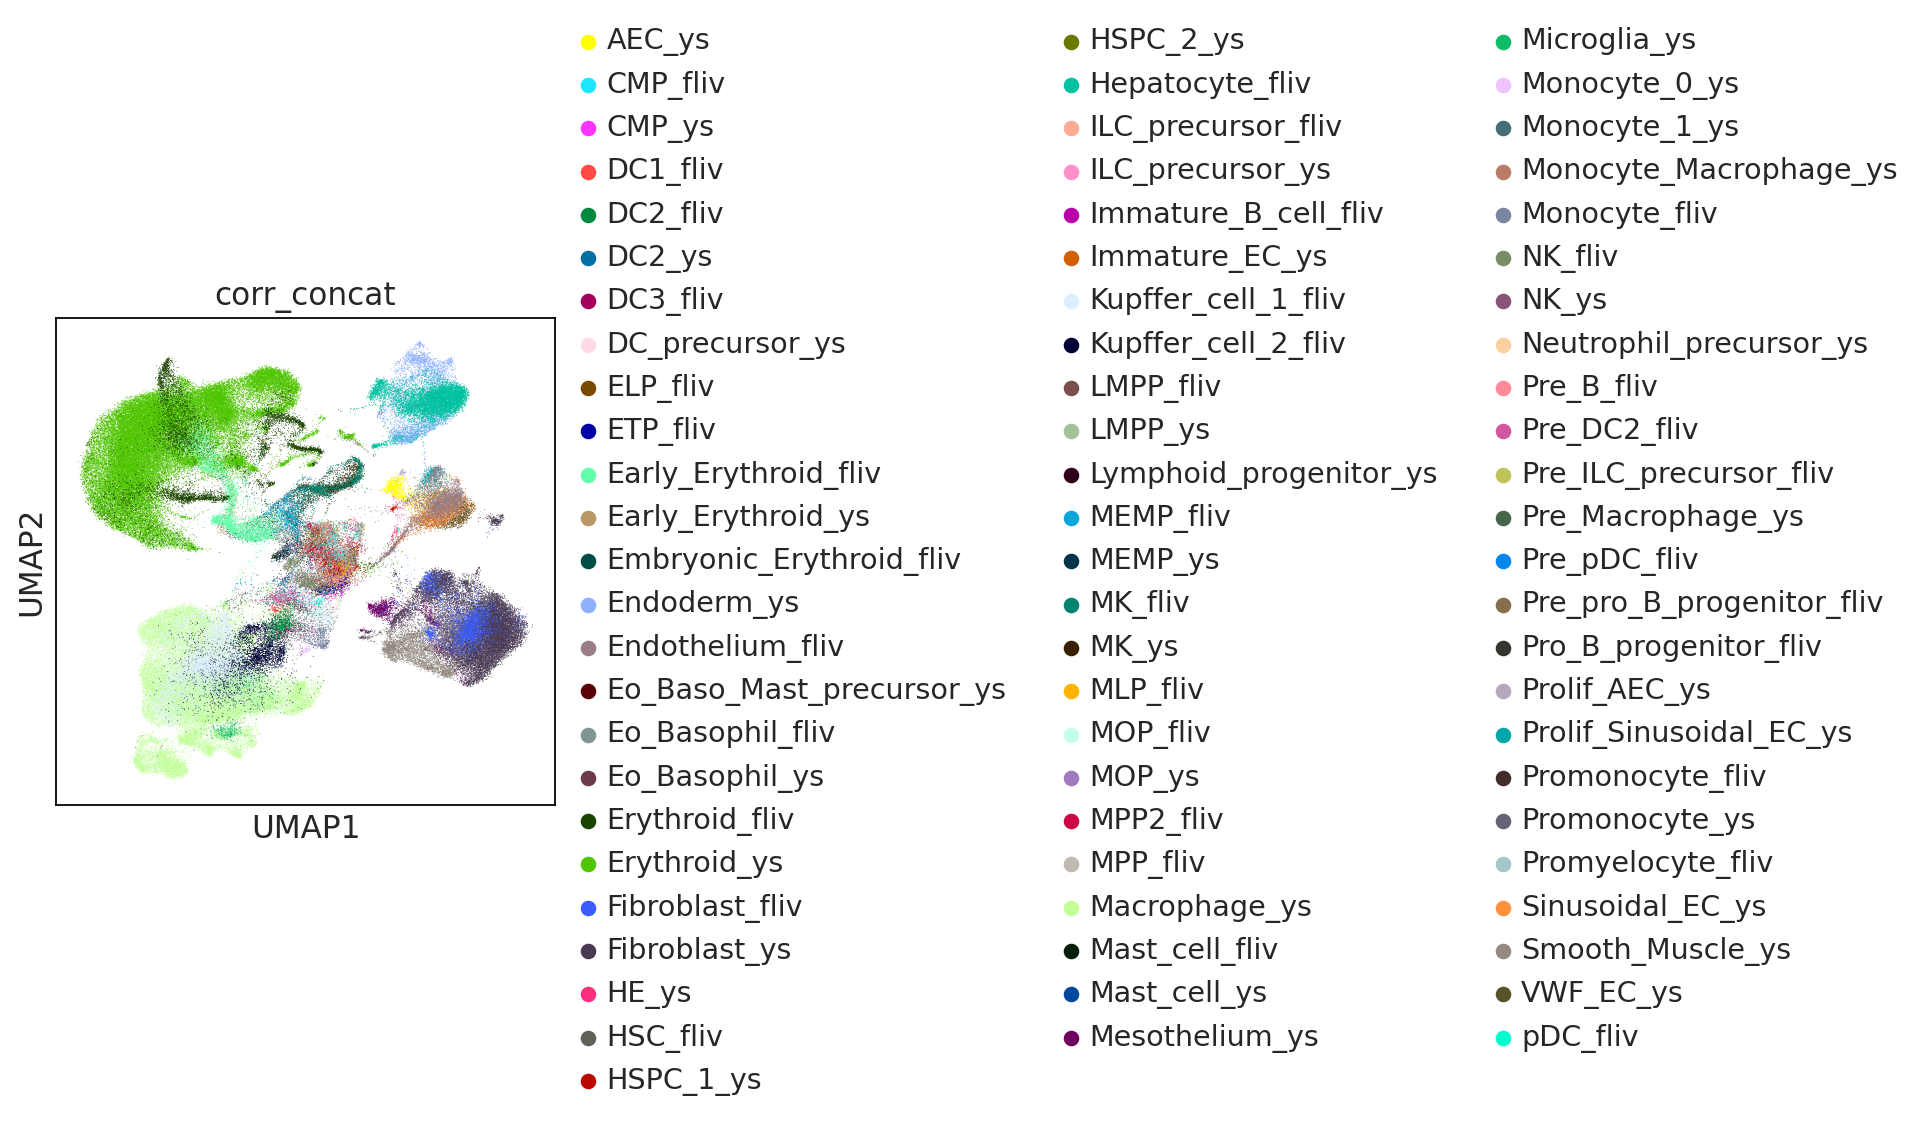

In [17]:
sc.pl.umap(adata,color='corr_concat')

## Logistic regression function to train data set and transfer labels

In [18]:
# This function require compute power, will take a while 

def LR_compare(adata, train_x, train_label, subset_predict, subset_train, penalty=penalty, sparcity=sparcity, 
               col_name='predicted'):

    # adata - training+prediction adata object (combined). Pre-processed already
    # sparsity - larger sparsity, more bins, more conservative predictions, less accurate. Low sparist for clean output
                # A value of 0.2 is reasonable for L2 ridge regression
    # penalty - acts as buffer for assigning bins too harshly
    # train_x - arg refers to where you would like to derive your training reference from, i.e., GEX (X) or/elif.
                # PCA/UMAP in obsm. The two 'if' statements below handle train_x differently based on this
                # Based on train_x, the loops below compute 'train_label' (cell type values in training/landscape data) 
                # and 'predict_x'(prediction data equivalent of train_x)
    # train_label - cell type values in training/landscape data
    # subset_predict - mandatory subset of predict_x which contains metadata for expression
    # subset_train - mandatory subset of train_x which contains metadata for expression
    
    # Redefine LR parameters 'penalty' and 'sparsity' if you would like to deviate from defaults set above
    
    # Assign 'lr' as sklearn logistic regression func, with penalty and sparsity defined above
    lr = LogisticRegression(penalty = penalty, C = sparcity, max_iter =  max_iter)
    
    if (penalty == "l1"):
        lr = LogisticRegression(penalty = penalty, C = sparcity, max_iter =  max_iter, dual = True, solver = 'liblinear')
    if (penalty == "elasticnet"):
        lr = LogisticRegression(penalty = penalty, C = sparcity, max_iter =  max_iter, dual=False,solver = 'saga',l1_ratio=l1_ratio)

    if train_x == 'X':
        # Define training parameters
        train_label = adata.obs[common_cat].values
        train_label = train_label[subset_train]
        #train_x = adata.X,
        # Define prediction parameters
        #predict_x = train_x
        #train_x = train_x[subset_train, :] # issue line! subset_train = np.array(adata.obs[common_cat].isin(group1))
                                           # group1 = (adata.obs[common_cat][adata.obs[common_cat].str.contains(Data1_group)]).unique()
                                           # Data1_group = data1 = healthy skin data , adata containing subsetting data to get metadata for expression prediction
                                           # adata.X = adata.X[np.array(adata.obs[common_cat].isin(group1)), :]
                                           # train_x = train_x[adata.obs[common_cat].isin(group1)]
                        
        #predict_x = train_x
        #predict_x = predict_x[subset_predict]
        train_x = adata.X[adata.obs.index.isin(list(adata.obs[subset_train].index))]
        predict_x = adata.X[adata.obs.index.isin(list(adata.obs[subset_predict].index))]

    elif train_x in adata.obsm.keys():
        # Define training parameters
        train_label = adata.obs[common_cat].values
        train_label = train_label[subset_train]
        train_x = adata.obsm[train_x]
        predict_x = train_x
        train_x = train_x[subset_train, :]
        # Define prediction parameters
        predict_x = predict_x[subset_predict]
        predict_x = pd.DataFrame(predict_x)
        predict_x.index = adata.obs[subset_predict].index

    # Train predictive model using user defined partition labels (train_x ,train_label, predict_x)
    model = lr.fit(train_x, train_label)
    lr.fit(train_x, train_label)
    predict = lr.predict_proba(predict_x)

    # Create prediction table and map to adata.obs (in adata.obs["predict"] in the combined object), for the cells that
    # are in predict dataset
    predict = lr.predict(predict_x)
    predict = pd.DataFrame(predict)
    predict.index = adata.obs[subset_predict].index
    adata.obs[col_name] = adata.obs.index
    adata.obs[col_name] = adata.obs[col_name].map(predict[0])

# Function to plot heatmap by percentage
def plot_df_heatmap(df, cmap='viridis', title=None, figsize=(7, 7), rotation=90, save=None, **kwargs):
    fig, ax = plt.subplots(figsize=figsize)
    im = ax.imshow(df, cmap=cmap, aspect='auto', **kwargs)
    if 0 < rotation < 90:
        horizontalalignment = 'right'
    else:
        horizontalalignment = 'center'
    plt.xticks(
        range(len(df.columns)),
        df.columns,
        rotation=rotation,
        horizontalalignment=horizontalalignment,
    )
    plt.yticks(range(len(df.index)), df.index)
    if title:
        fig.suptitle(title)
    #fig.colorbar(im)
    if save:
        plt.savefig(fname=save, bbox_inches='tight', pad_inches=0.1)

# Plot probability table by html
def cross_table(adata, x, y, normalise=None, highlight=False, subset=None):                                                                                                                                                                                              
    """Make a cross table comparing two categorical annotations
    """
    x_attr = adata.obs[x]
    y_attr = adata.obs[y]
    if subset is not None:
        x_attr = x_attr[subset]
        y_attr = y_attr[subset]
    crs_tbl = pd.crosstab(x_attr, y_attr)
    if normalise == 'x':
        x_sizes = x_attr.groupby(x_attr).size().values
        crs_tbl = (crs_tbl.T / x_sizes).round(2).T
    elif normalise == 'y':
        y_sizes = x_attr.groupby(y_attr).size().values
        crs_tbl = (crs_tbl / y_sizes).round(2)
    if highlight:
        return crs_tbl.style.background_gradient(cmap='viridis', axis=0)
    return crs_tbl

# # Define the separator category in the column of interest, this works by partial matches and enables a-symmetric 
# # comparisons
# Data1_group = data1
# Data2_group = data2
# # Define the common .obs column between concatinated data
# common_cat = "corr_concat"

# # This block defines subset_predict and subset_train and also runs LR_compare function
# group1 = (adata.obs[common_cat][adata.obs[common_cat].str.contains(Data1_group)]).unique()
# group1 = list(group1)
# group2 = (adata.obs[common_cat][adata.obs[common_cat].str.contains(Data2_group)]).unique()
# group2 = list(group2)
# subset_predict = np.array(adata.obs[common_cat].isin(group2))
# subset_train = np.array(adata.obs[common_cat].isin(group1))
# train_label = (adata.obs[common_cat][adata.obs[common_cat].isin(group1)]).values

# LR_compare(adata, train_x, train_label, subset_predict, subset_train, sparcity=sparcity, col_name='predicted')

# ################################################################################################################################################################
# #HTML cross-table construction

# # Plotting purposes - Subset data to only contain prediction data with new predicted labelså
# # Make adata the predicted data with projected annotations in adata.obs["predicted"]. "corr_concat" contains old 
# # cell.labels and dataset name combined 
# common_cat = "corr_concat"
# adata_concat = adata[:]
# adata = adata[adata.obs["predicted"].isin(group1)]
# adata = adata[adata.obs["corr_concat"].isin(group2)]

# # The results, are displayed in a python notebook or rendered as a html (just for quick visualisation, not saving)
# # This table represents probability (binary cell type assignment) - numbers represent number of cells
# # Columns contain number of original cells from adata2 that are now labelled using the training dataset, adata1
# # (as shown on y axis)
# crs_tbl = cross_table(adata, x = 'predicted', y = common_cat, highlight = True)
# #crs_tbl

# ################################################################################################################################################################
# # Heatmap function

# x = 'predicted'
# y = common_cat

# y_attr = adata.obs[y]
# x_attr = adata.obs[x]
# crs = pd.crosstab(x_attr, y_attr)
# crs_tbl = crs
# for col in crs_tbl :
#     crs_tbl[col] = crs_tbl[col].div(crs_tbl[col].sum(axis=0)).multiply(100).round(2)
# # Sort df columns by rows
# crs_tbl = crs_tbl.sort_values(by =list(crs_tbl.index), axis=1,ascending=False)
# # Plot_df_heatmap(crs_tbl, cmap='coolwarm', rotation=90, vmin=20, vmax=70)
# pal = sns.diverging_palette(240, 10, n=10)
# plt.figure(figsize=(20,15))
# sns.set(font_scale=0.8)
# g = sns.heatmap(crs_tbl, cmap=pal, vmin=0, vmax=100, linewidths=1, center=50, square=True, cbar_kws={"shrink": 0.5})
# plt.xlabel("Original labels")
# plt.ylabel("Predicted labels")
# plt.savefig(save_path + "/LR_predictions.pdf")
# crs_tbl.to_csv(save_path + "/pre-freq_LR_predictions_supp_table.csv")

In [19]:
# Define the separator category in the column of interest, this works by partial matches and enables a-symmetric 
# comparisons
Data1_group = data1
Data2_group = data2
# Define the common .obs column between concatinated data
common_cat = "corr_concat"

# This block defines subset_predict and subset_train and also runs LR_compare function
group1 = (adata.obs[common_cat][adata.obs[common_cat].str.contains(Data1_group)]).unique()
group1 = list(group1)
group2 = (adata.obs[common_cat][adata.obs[common_cat].str.contains(Data2_group)]).unique()
group2 = list(group2)
subset_predict = np.array(adata.obs[common_cat].isin(group2))
subset_train = np.array(adata.obs[common_cat].isin(group1))
train_label = (adata.obs[common_cat][adata.obs[common_cat].isin(group1)]).values

In [20]:
    penalty = "elasticnet"
    common_cat = 'corr_concat'
    col_name='predicted'
    train_x = 'X'
    # adata - training+prediction adata object (combined). Pre-processed already
    # sparsity - larger sparsity, more bins, more conservative predictions, less accurate. Low sparist for clean output
                # A value of 0.2 is reasonable for L2 ridge regression
    # penalty - acts as buffer for assigning bins too harshly
    # train_x - arg refers to where you would like to derive your training reference from, i.e., GEX (X) or/elif.
                # PCA/UMAP in obsm. The two 'if' statements below handle train_x differently based on this
                # Based on train_x, the loops below compute 'train_label' (cell type values in training/landscape data) 
                # and 'predict_x'(prediction data equivalent of train_x)
    # train_label - cell type values in training/landscape data
    # subset_predict - mandatory subset of predict_x which contains metadata for expression
    # subset_train - mandatory subset of train_x which contains metadata for expression
    
    # Redefine LR parameters 'penalty' and 'sparsity' if you would like to deviate from defaults set above
    
    # Assign 'lr' as sklearn logistic regression func, with penalty and sparsity defined above
    lr = LogisticRegression(penalty = penalty, C = sparcity, max_iter =  max_iter)
    
    if (penalty == "l1"):
        lr = LogisticRegression(penalty = penalty, C = sparcity, max_iter =  max_iter, dual = True, solver = 'liblinear',multi_class = 'ovr' ) # one-vs-rest
    if (penalty == "elasticnet"):
        lr = LogisticRegression(penalty = penalty, C = sparcity, max_iter =  max_iter, dual=False,solver = 'saga',l1_ratio=l1_ratio,multi_class = 'multinomial')

    if train_x == 'X':
        # Define training parameters
        train_label = adata.obs[common_cat].values
        predict_label = train_label[subset_predict]
        train_label = train_label[subset_train]
        train_x = adata.X[adata.obs.index.isin(list(adata.obs[subset_train].index))]
        predict_x = adata.X[adata.obs.index.isin(list(adata.obs[subset_predict].index))]

    elif train_x in adata.obsm.keys():
        # Define training parameters
        train_label = adata.obs[common_cat].values
        predict_label = train_label[subset_predict]
        train_label = train_label[subset_train]
        train_x = adata.obsm[train_x]
        predict_x = train_x
        train_x = train_x[subset_train, :]
        # Define prediction parameters
        predict_x = predict_x[subset_predict]
        predict_x = pd.DataFrame(predict_x)
        predict_x.index = adata.obs[subset_predict].index

    # Train predictive model using user defined partition labels (train_x ,train_label, predict_x)
    lr.fit(train_x, train_label)
    predict_proba = lr.predict_proba(predict_x)

    # Create prediction table and map to adata.obs (in adata.obs["predict"] in the combined object), for the cells that
    # are in predict dataset
    predict = lr.predict(predict_x)
    predict = pd.DataFrame(predict)
    predict.index = adata.obs[subset_predict].index
    adata.obs[col_name] = adata.obs.index
    adata.obs[col_name] = adata.obs[col_name].map(predict[0])

/home/jovyan/my-conda-envs/workhorse/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


In [29]:
predict = lr.predict(predict_x)
predict_proba = lr.predict_proba(predict_x)
predict

array(['HSPC_2_ys', 'Macrophage_ys', 'Macrophage_ys', ..., 'MEMP_ys',
       'Early_Erythroid_ys', 'Early_Erythroid_ys'], dtype=object)

In [30]:
dir(lr)
lr.intercept_
lr.coef_
lr.classes_

array(['AEC_ys', 'CMP_ys', 'DC2_ys', 'DC_precursor_ys',
       'Early_Erythroid_ys', 'Endoderm_ys', 'Eo_Baso_Mast_precursor_ys',
       'Eo_Basophil_ys', 'Erythroid_ys', 'Fibroblast_ys', 'HE_ys',
       'HSPC_1_ys', 'HSPC_2_ys', 'ILC_precursor_ys', 'Immature_EC_ys',
       'LMPP_ys', 'Lymphoid_progenitor_ys', 'MEMP_ys', 'MK_ys', 'MOP_ys',
       'Macrophage_ys', 'Mast_cell_ys', 'Mesothelium_ys', 'Microglia_ys',
       'Monocyte_0_ys', 'Monocyte_1_ys', 'Monocyte_Macrophage_ys',
       'NK_ys', 'Neutrophil_precursor_ys', 'Pre_Macrophage_ys',
       'Prolif_AEC_ys', 'Prolif_Sinusoidal_EC_ys', 'Promonocyte_ys',
       'Sinusoidal_EC_ys', 'Smooth_Muscle_ys', 'VWF_EC_ys'], dtype=object)

In [41]:
# save the model to disk
model = lr
filename = './X_ys_matched_fliv.sav'
pkl.dump(model, open(filename, 'wb'))

In [42]:
lr.intercept_

array([-2.61457171e-04, -2.90450262e-04, -1.50720691e-04,  1.34484726e-04,
       -2.70597957e-04, -5.82312205e-05, -1.86537392e-04, -4.94725828e-04,
        1.15822675e-03,  2.70623248e-04,  2.79535336e-04,  5.67085342e-04,
        1.42639401e-04,  1.20326564e-04,  5.31756377e-04, -2.45944713e-04,
        2.59124296e-04,  8.31153229e-05,  5.33434388e-04, -2.60574277e-04,
        4.96533525e-04,  7.81483759e-05,  9.91569686e-05, -5.33197075e-04,
        2.36893702e-05, -8.46793409e-05, -2.42968803e-04,  2.94730184e-04,
        2.47786433e-04, -5.63446025e-04, -2.85720249e-04, -4.96741442e-04,
       -1.51511224e-04, -5.19816065e-04, -4.01890691e-04, -2.96219077e-04],
      dtype=float32)

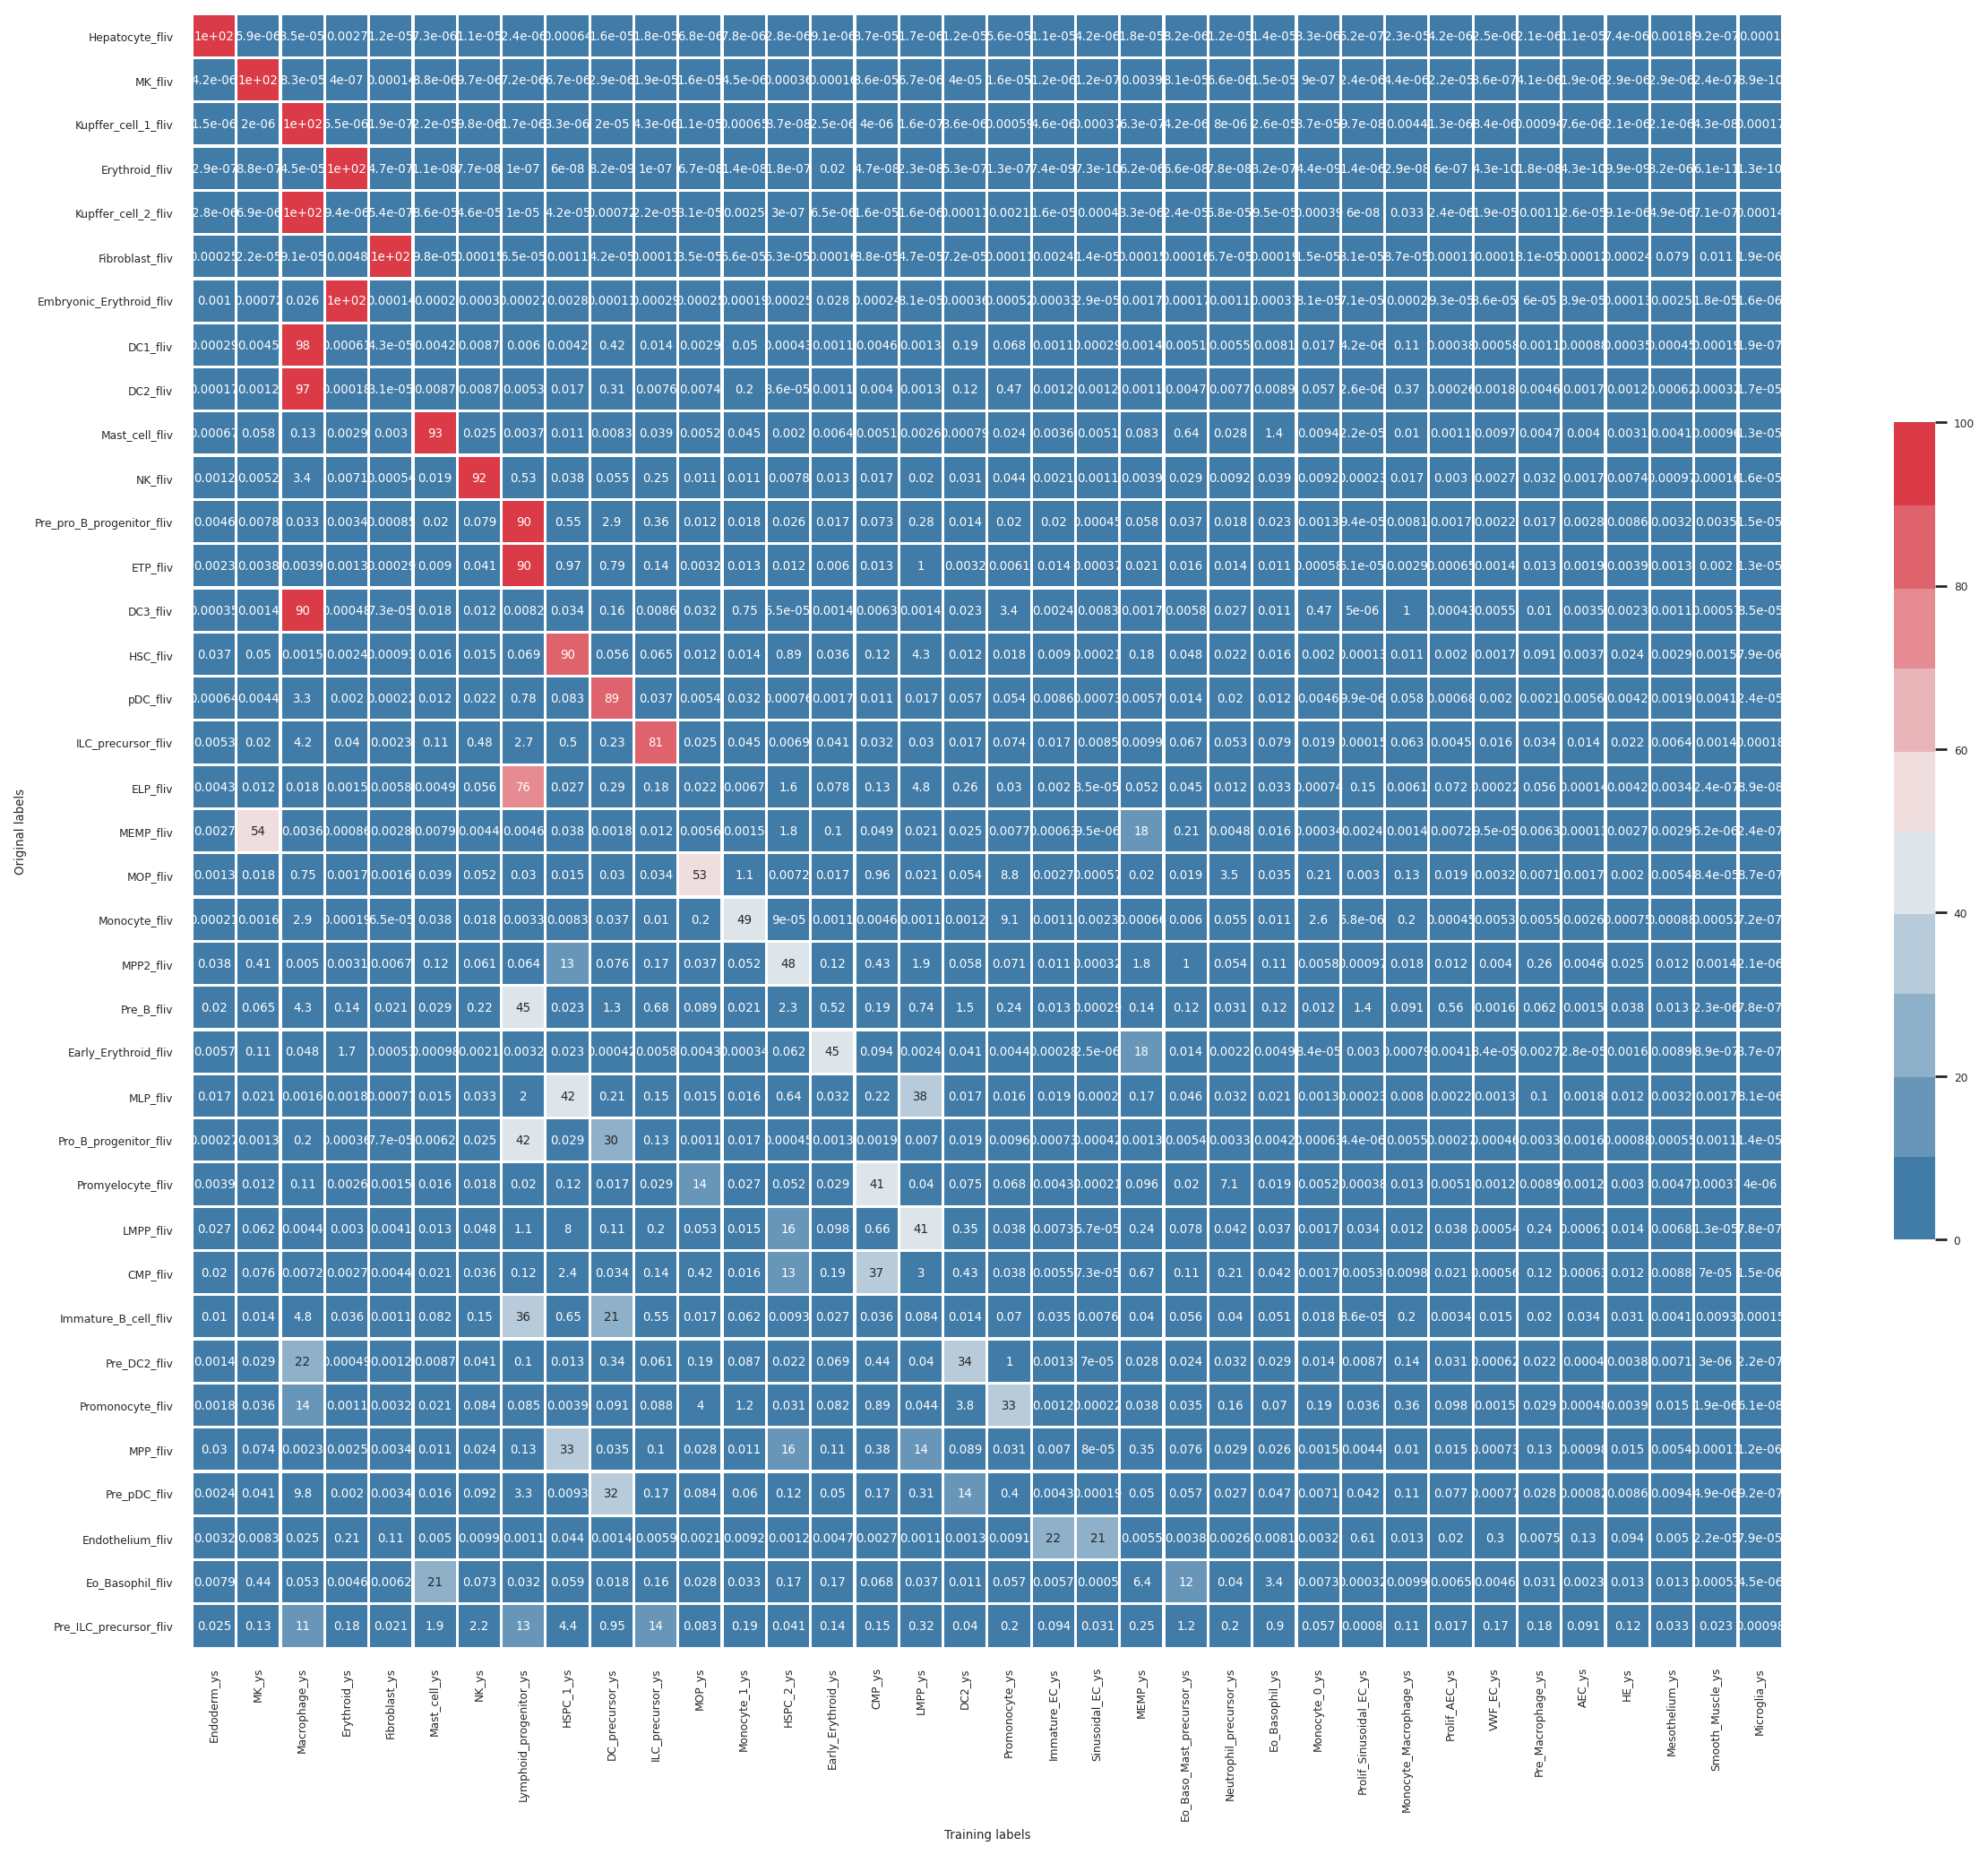

In [52]:
model = lr
train_label = adata.obs[common_cat].values
predict_label = train_label[subset_predict]

pred_out = pd.DataFrame(model.predict(predict_x),columns = ['predicted'],index = adata.obs.index[adata.obs[common_cat].isin(group2)])
pred_out['orig_labels'] = predict_label
proba = pd.DataFrame(model.predict_proba(predict_x),columns = lr.classes_,index = adata.obs.index[adata.obs[common_cat].isin(group2)])
pred_out = pred_out.join(proba)
pred_out

#model_mean_probs = pred_out.loc[:, pred_out.columns != 'predicted'].groupby('orig_labels').mean()
model_mean_probs = pred_out.loc[:, pred_out.columns != 'predicted'].groupby('orig_labels').median()
model_mean_probs = model_mean_probs*100
model_mean_probs = model_mean_probs.dropna(axis=0, how='any', thresh=None, subset=None, inplace=False)
crs_tbl = model_mean_probs.copy()

# Keep only predictions with probs >20
#crs_tbl = crs_tbl[crs_tbl.columns[crs_tbl.max() > trim]]

# Keep only predicted labels with probs >20
#crs_tbl = crs_tbl[crs_tbl.max(axis=1) > trim]

# Sort df columns by rows

#crs_tbl = crs_tbl.sort_values(by =list(crs_tbl.index), axis=1,ascending=False)
#crs_tbl = crs_tbl.sort_values(by =list(crs_tbl.columns), axis=0,ascending=False)

index_order = list(crs_tbl.max(axis=1).sort_values(ascending=False).index)
crs_tbl = crs_tbl.loc[index_order]
col_order = list(crs_tbl.max(axis=0).sort_values(ascending=False).index)
crs_tbl = crs_tbl[col_order]

# Plot_df_heatmap(crs_tbl, cmap='coolwarm', rotation=90, vmin=20, vmax=70)
pal = sns.diverging_palette(240, 10, n=10)
plt.figure(figsize=(20,15))
sns.set(font_scale=0.5)
g = sns.heatmap(crs_tbl, cmap=pal,  annot=True,vmin=0, vmax=100, linewidths=1, center=50, square=True, cbar_kws={"shrink": 0.5})
plt.ylabel("Original labels")
plt.xlabel("Training labels")

plt.savefig('./ver9_220401_lr_X_model_means_clusters.pdf',dpi=300)

In [46]:
pred_out.to_csv('./040422_LR_X_pred_out.csv')

In [39]:
# save the model to disk
# model = lr
# filename = './low_dim_ys_matched_fliv.sav'
# pkl.dump(model, open(filename, 'wb'))

# QC

In [78]:
#Dump prediction that are <0.7
pred_out = pd.DataFrame(model.predict(predict_x),columns = ['predicted'],index = adata.obs.index[adata.obs[common_cat].isin(group2)])
pred_out['orig_labels'] = predict_label
proba = pd.DataFrame(model.predict_proba(predict_x),columns = lr.classes_,index = adata.obs.index[adata.obs[common_cat].isin(group2)])
pred_out = pred_out.join(proba)

# Filter for only cells which have > 70% predictive probability
pred_out = pred_out[pred_out.max(axis=1)>0.9]
# Remove all predictions under 5 counts
pred_out = pred_out[pred_out['predicted'].isin((pred_out.groupby(['predicted']).size()[~(pred_out.groupby(['predicted']).size() < 5)]).index)]

<ipython-input-78-3b784a93eda2>:8: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  pred_out = pred_out[pred_out.max(axis=1)>0.9]


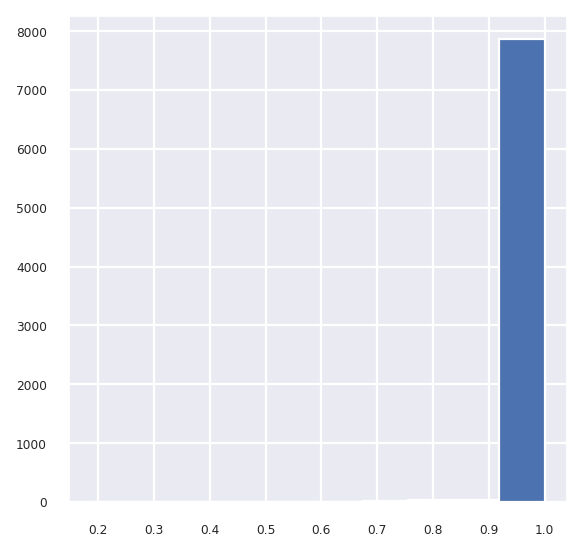

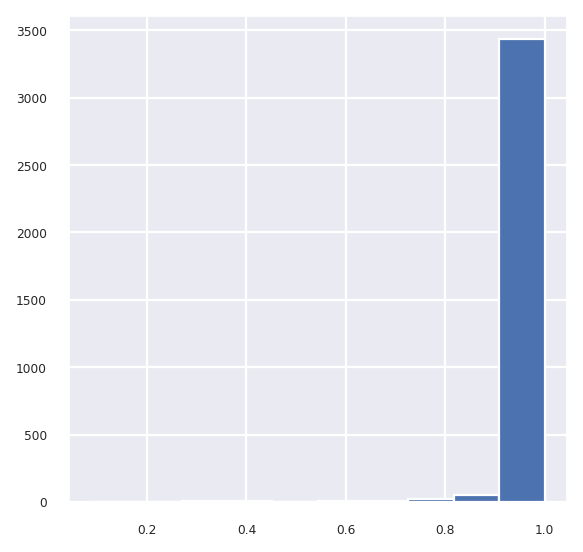

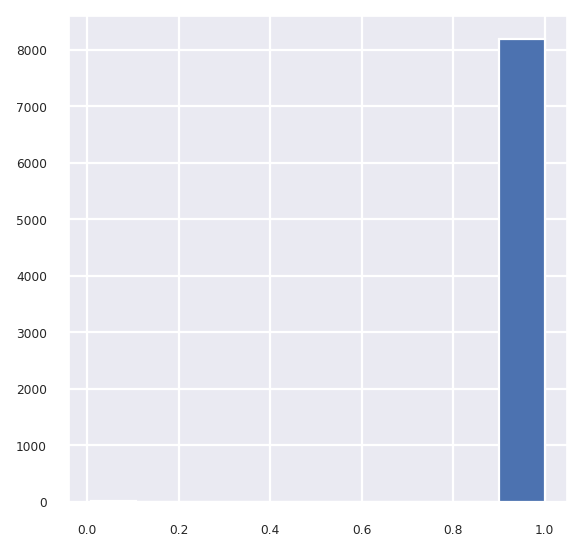

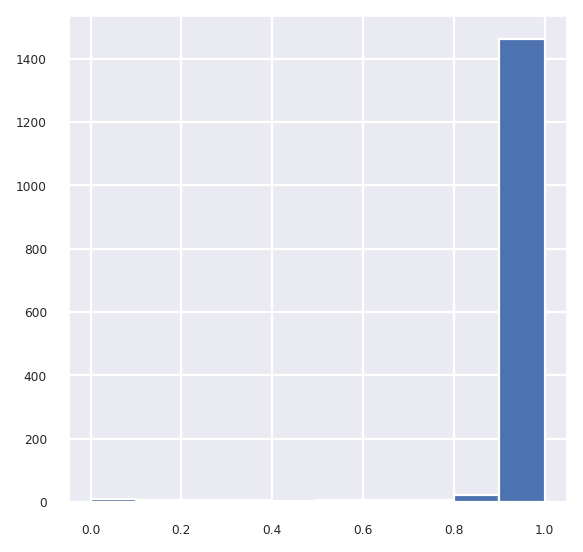

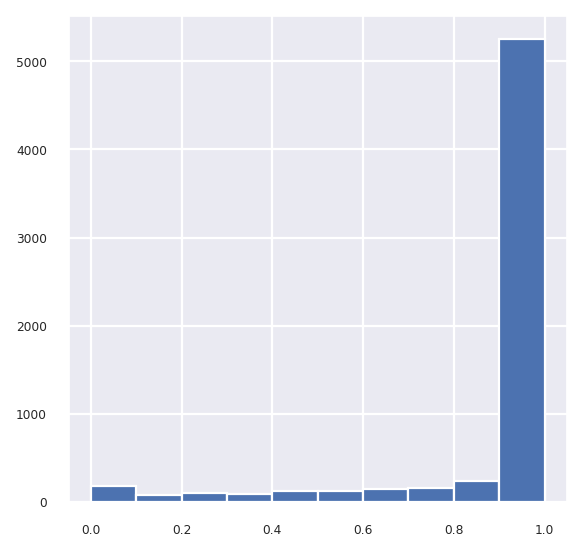

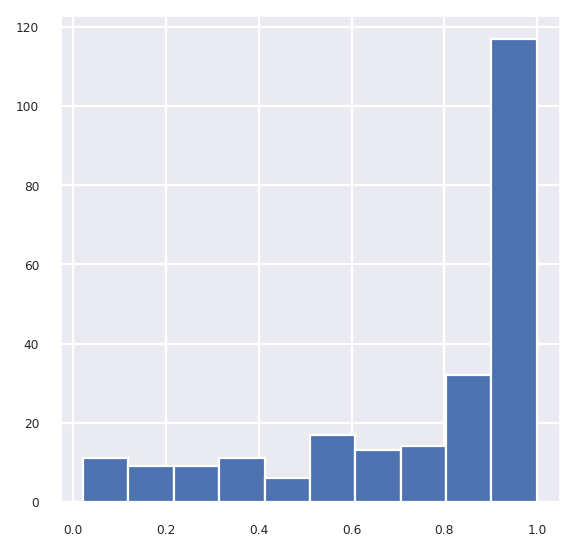

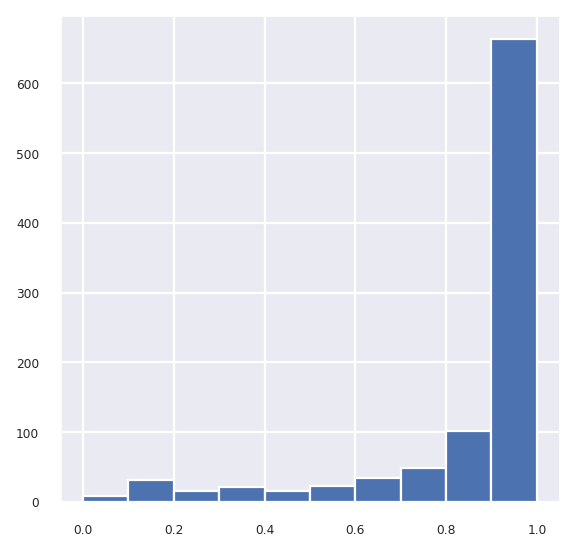

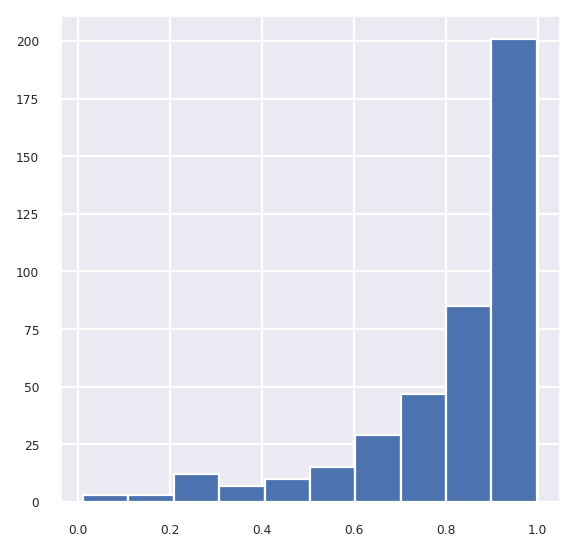

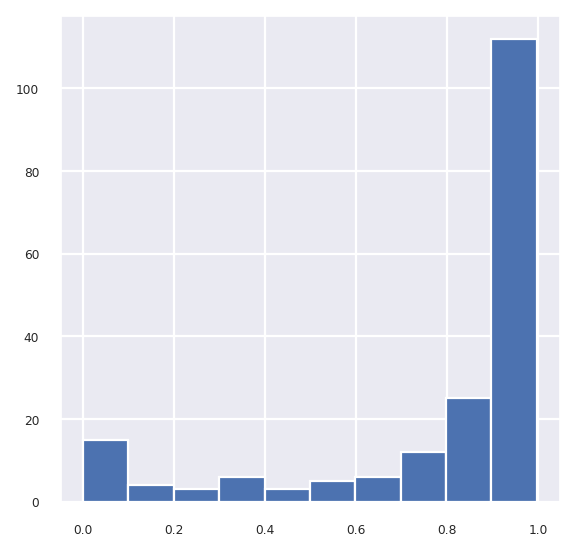

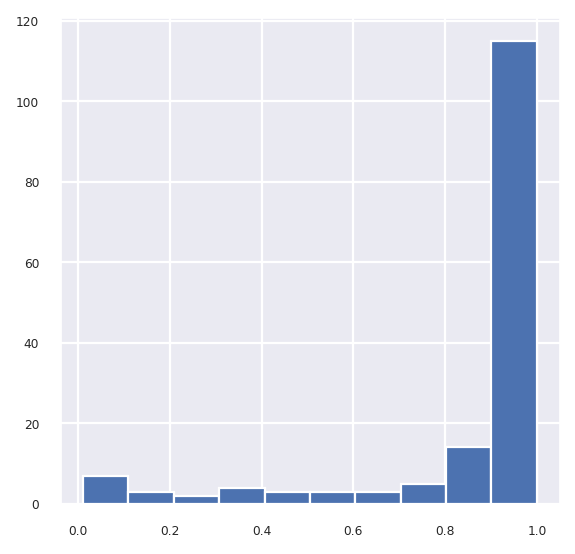

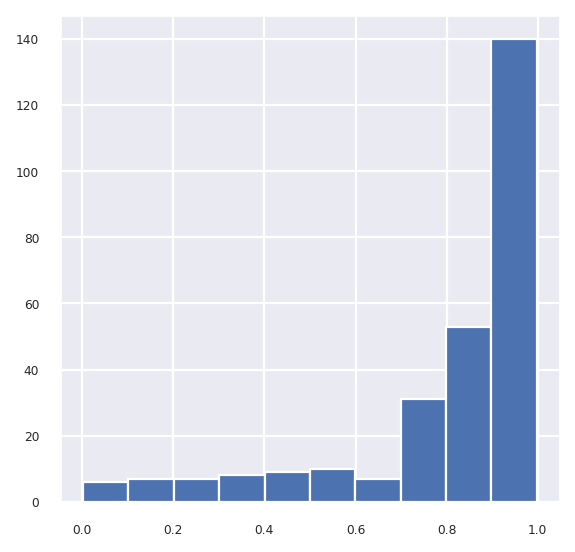

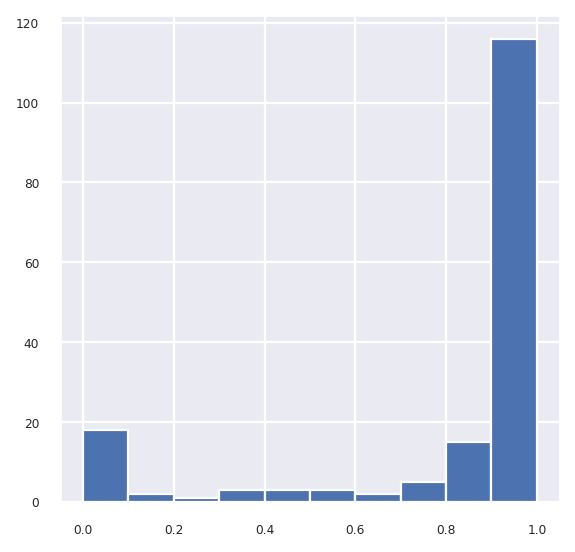

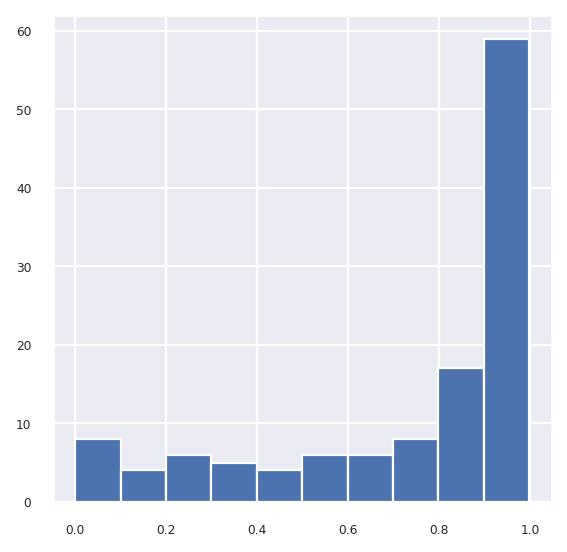

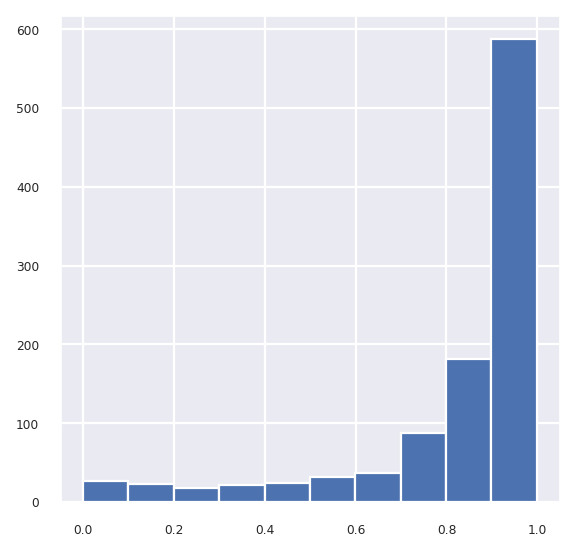

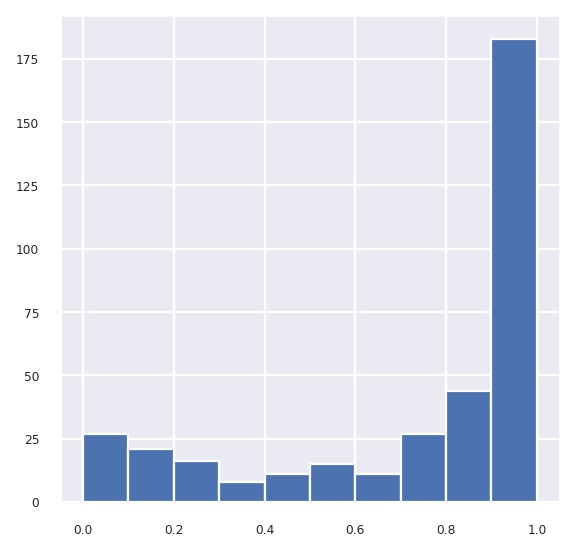

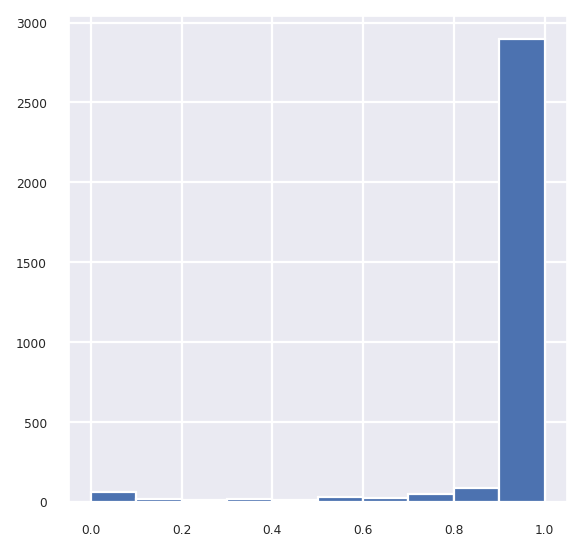

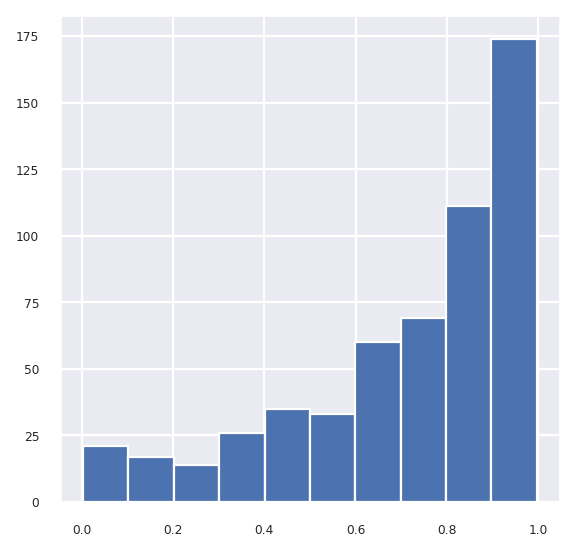

In [48]:
from scipy import stats
remove_concat = []
for data2_predict in (pred_out['orig_labels'].unique()):
    QC_dist = pred_out[pred_out['orig_labels'].isin([data2_predict])]
    QC_dist = QC_dist.loc[:, QC_dist.columns.str.contains(data1)] #'_ys'
    for i in QC_dist.columns:
        if min(QC_dist[i])< np.mean(QC_dist[i]) - (1.96*np.std(QC_dist[i])):
            remove = QC_dist.index[QC_dist[i]< (np.mean(QC_dist[i]) - (1.96*np.std(QC_dist[i])))]
            plt.hist(QC_dist[i],bins=10)
            remove_concat = list(remove) + remove_concat
            plt.show()
pred_out = pred_out[~pred_out.index.isin(remove_concat)]

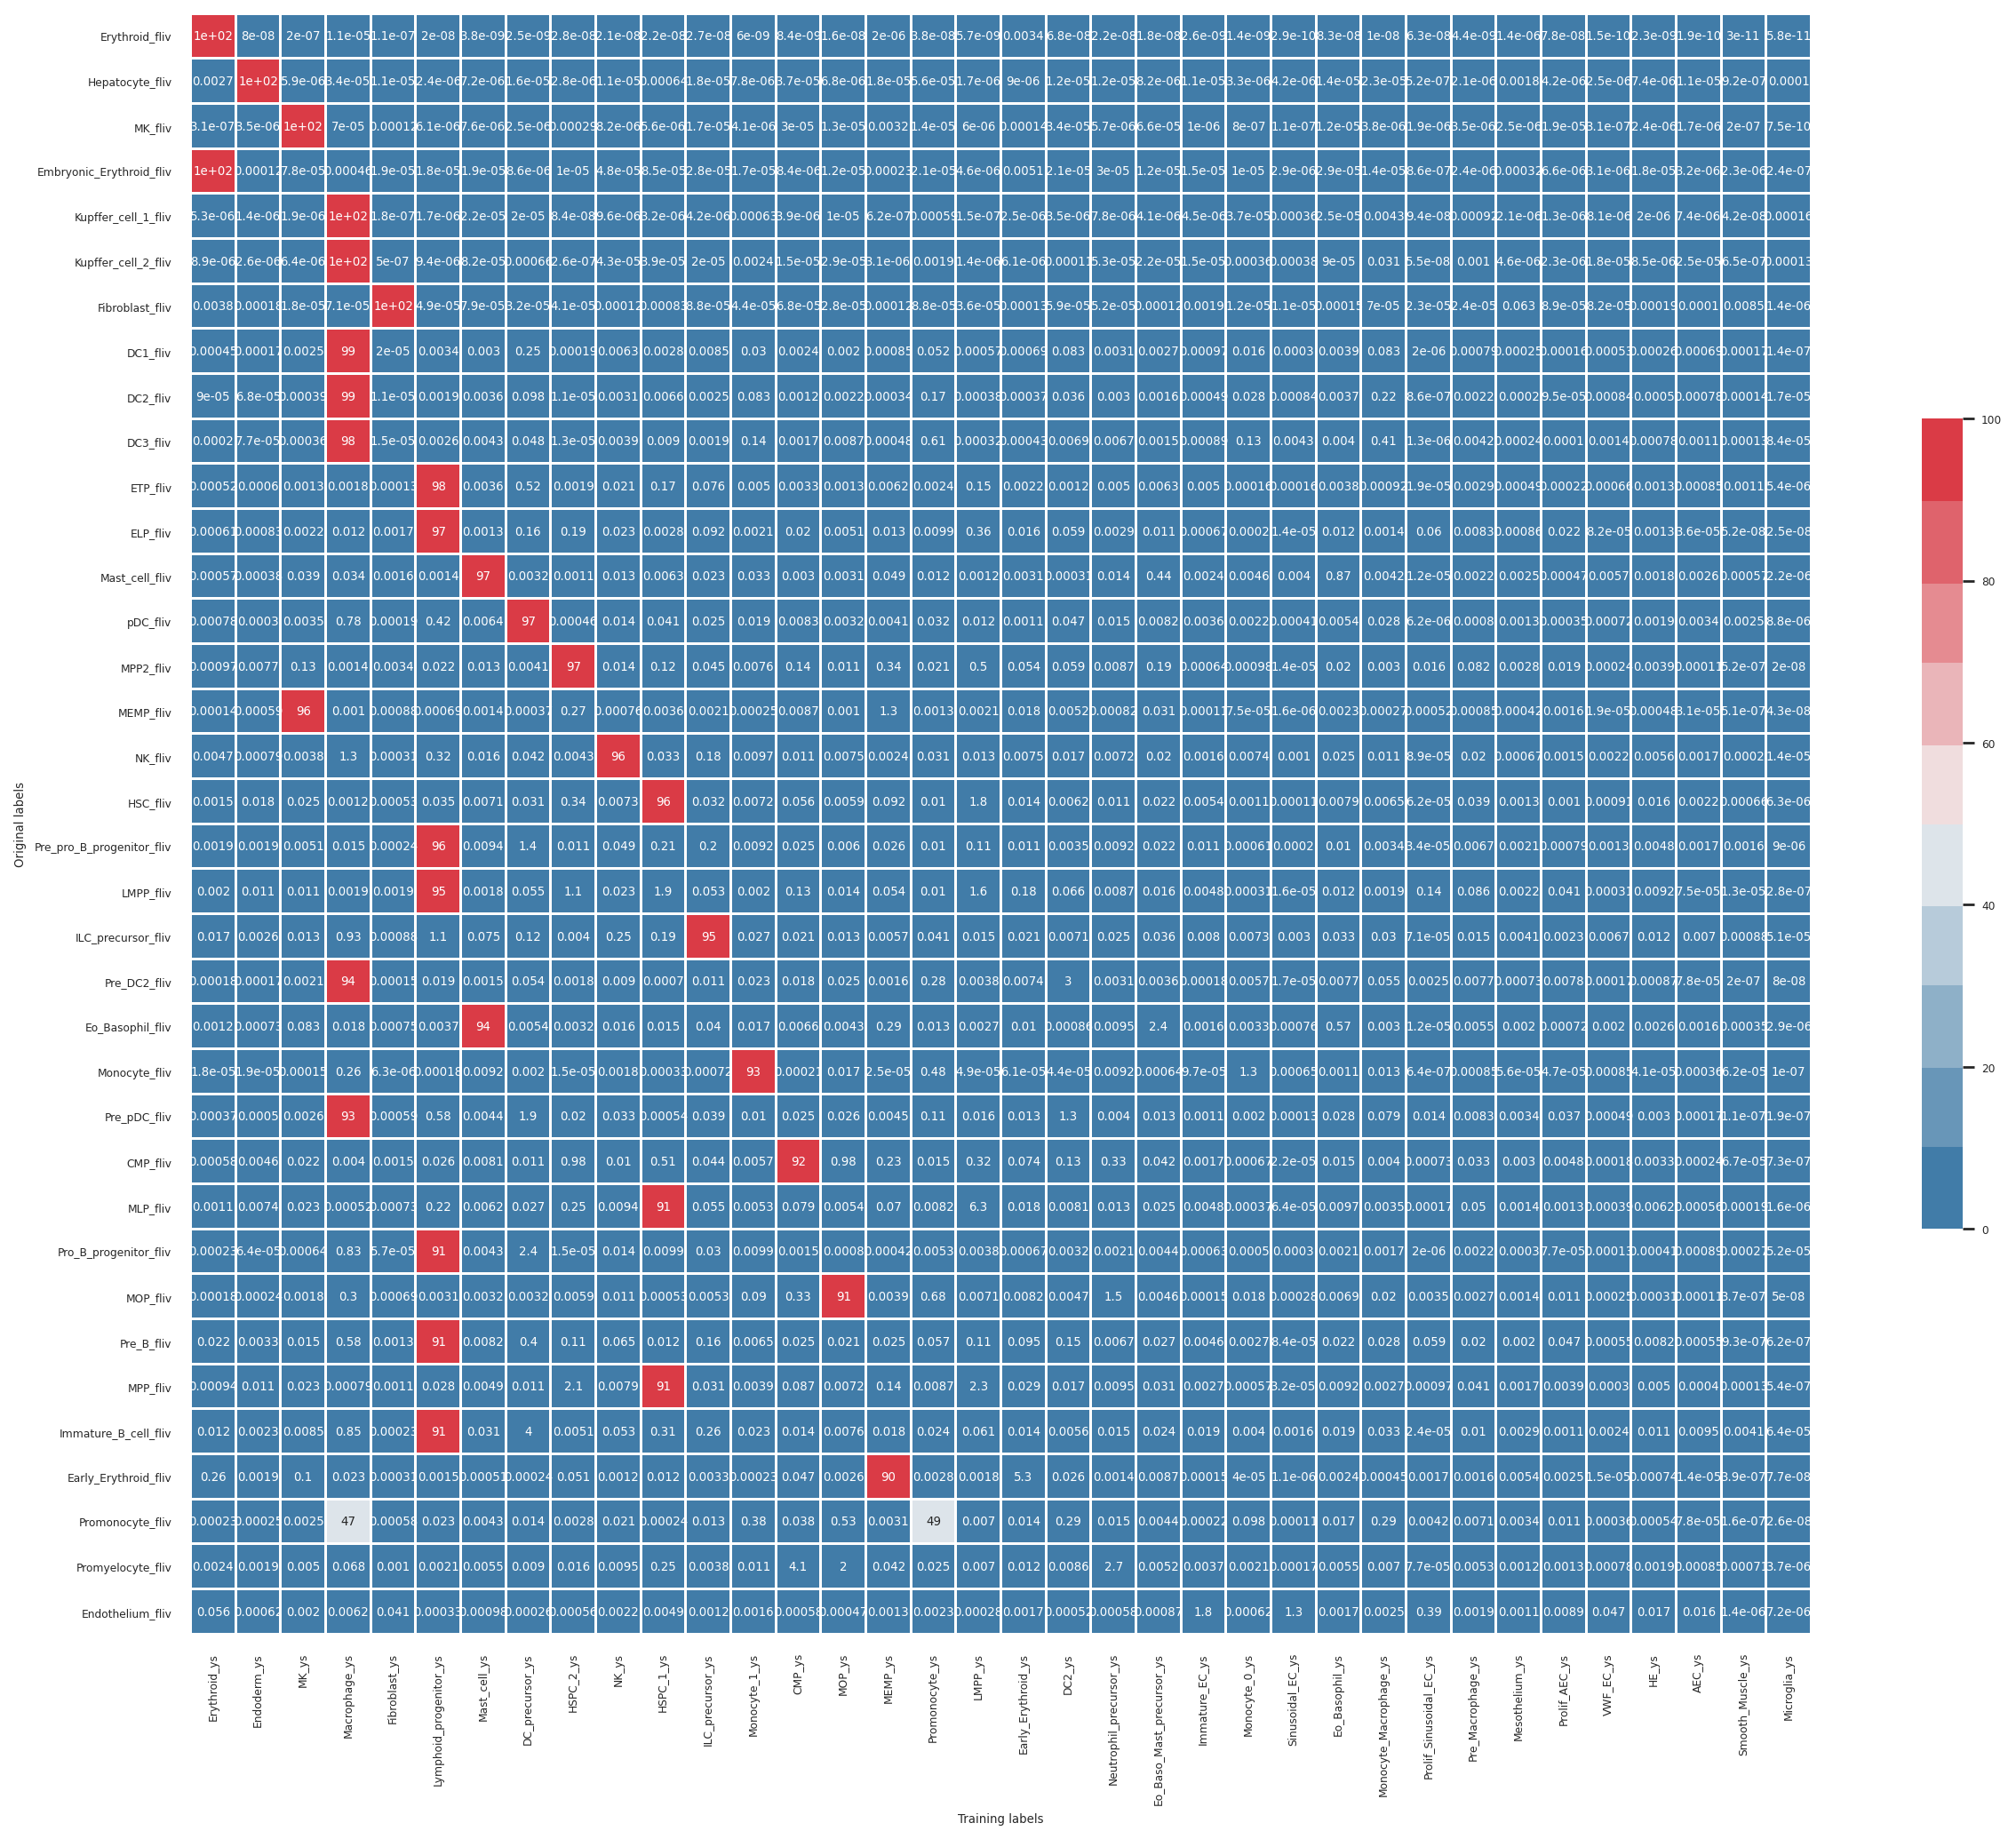

In [79]:
#model_mean_probs = pred_out.loc[:, pred_out.columns != 'predicted'].groupby('orig_labels').mean()
model_mean_probs = pred_out.loc[:, pred_out.columns != 'predicted'].groupby('orig_labels').median()
model_mean_probs = model_mean_probs*100
model_mean_probs = model_mean_probs.dropna(axis=0, how='any', thresh=None, subset=None, inplace=False)
crs_tbl = model_mean_probs.copy()

# Keep only predictions with probs >20
#crs_tbl = crs_tbl[crs_tbl.columns[crs_tbl.max() > trim]]

# Keep only predicted labels with probs >20
#crs_tbl = crs_tbl[crs_tbl.max(axis=1) > trim]

# Sort df columns by rows

#crs_tbl = crs_tbl.sort_values(by =list(crs_tbl.index), axis=1,ascending=False)
#crstbl = crs_tbl.sort_values(by =list(crs_tbl.columns), axis=0,ascending=False)

index_order = list(crs_tbl.max(axis=1).sort_values(ascending=False).index)
crs_tbl = crs_tbl.loc[index_order]
col_order = list(crs_tbl.max(axis=0).sort_values(ascending=False).index)
crs_tbl = crs_tbl[col_order]

# Plot_df_heatmap(crs_tbl, cmap='coolwarm', rotation=90, vmin=20, vmax=70)
pal = sns.diverging_palette(240, 10, n=10)
plt.figure(figsize=(20,15))
sns.set(font_scale=0.5)
g = sns.heatmap(crs_tbl, cmap=pal,  annot=True,vmin=0, vmax=100, linewidths=1, center=50, square=True, cbar_kws={"shrink": 0.5})
plt.ylabel("Original labels")
plt.xlabel("Training labels")

plt.savefig('./ver9_220401_lr_model_qc_means_clusters.pdf',dpi=300)

# Read new, reorder and plot

In [83]:
sort_fliv = ["HSC_fliv",
"MPP_fliv",
"MPP2_fliv",
"CMP_fliv",
"MEMP_fliv",
"LMPP_fliv",
"MLP_fliv",
"ELP_fliv",
"ETP_fliv",
"MOP_fliv",
"Pre_pro_B_progenitor_fliv",
"Pro_B_progenitor_fliv",
"Pre_B_fliv",
"Immature_B_cell_fliv",
#"Pre_ILC_precursor_fliv",
"ILC_precursor_fliv",
"NK_fliv",
"Pre_pDC_fliv",
"pDC_fliv",
"DC1_fliv",
"Pre_DC2_fliv",
"DC2_fliv",
"DC3_fliv",
"Promonocyte_fliv",
"Monocyte_fliv",
"Kupffer_cell_1_fliv",
"Kupffer_cell_2_fliv",
"Promyelocyte_fliv",
"Eo_Basophil_fliv",
"Mast_cell_fliv",
"MK_fliv",
"Early_Erythroid_fliv",
"Embryonic_Erythroid_fliv",
"Erythroid_fliv",]

In [84]:
sort_ys = ["HSPC_1_ys",
"HSPC_2_ys",
"CMP_ys",
"MEMP_ys",
"LMPP_ys",
"Lymphoid_progenitor_ys",
"MOP_ys",
"ILC_precursor_ys",
"NK_ys",
"DC_precursor_ys",
"DC2_ys",
"Promonocyte_ys",
'Monocyte_0_ys',
 'Monocyte_1_ys',
"Monocyte_Macrophage_ys",
"Pre_Macrophage_ys",
"Macrophage_ys",
"Microglia_ys",
"Neutrophil_precursor_ys",
"Eo_Baso_Mast_precursor_ys",
"Eo_Basophil_ys",
"Mast_cell_ys",
"MK_ys",
"Early_Erythroid_ys",
"Erythroid_ys",]

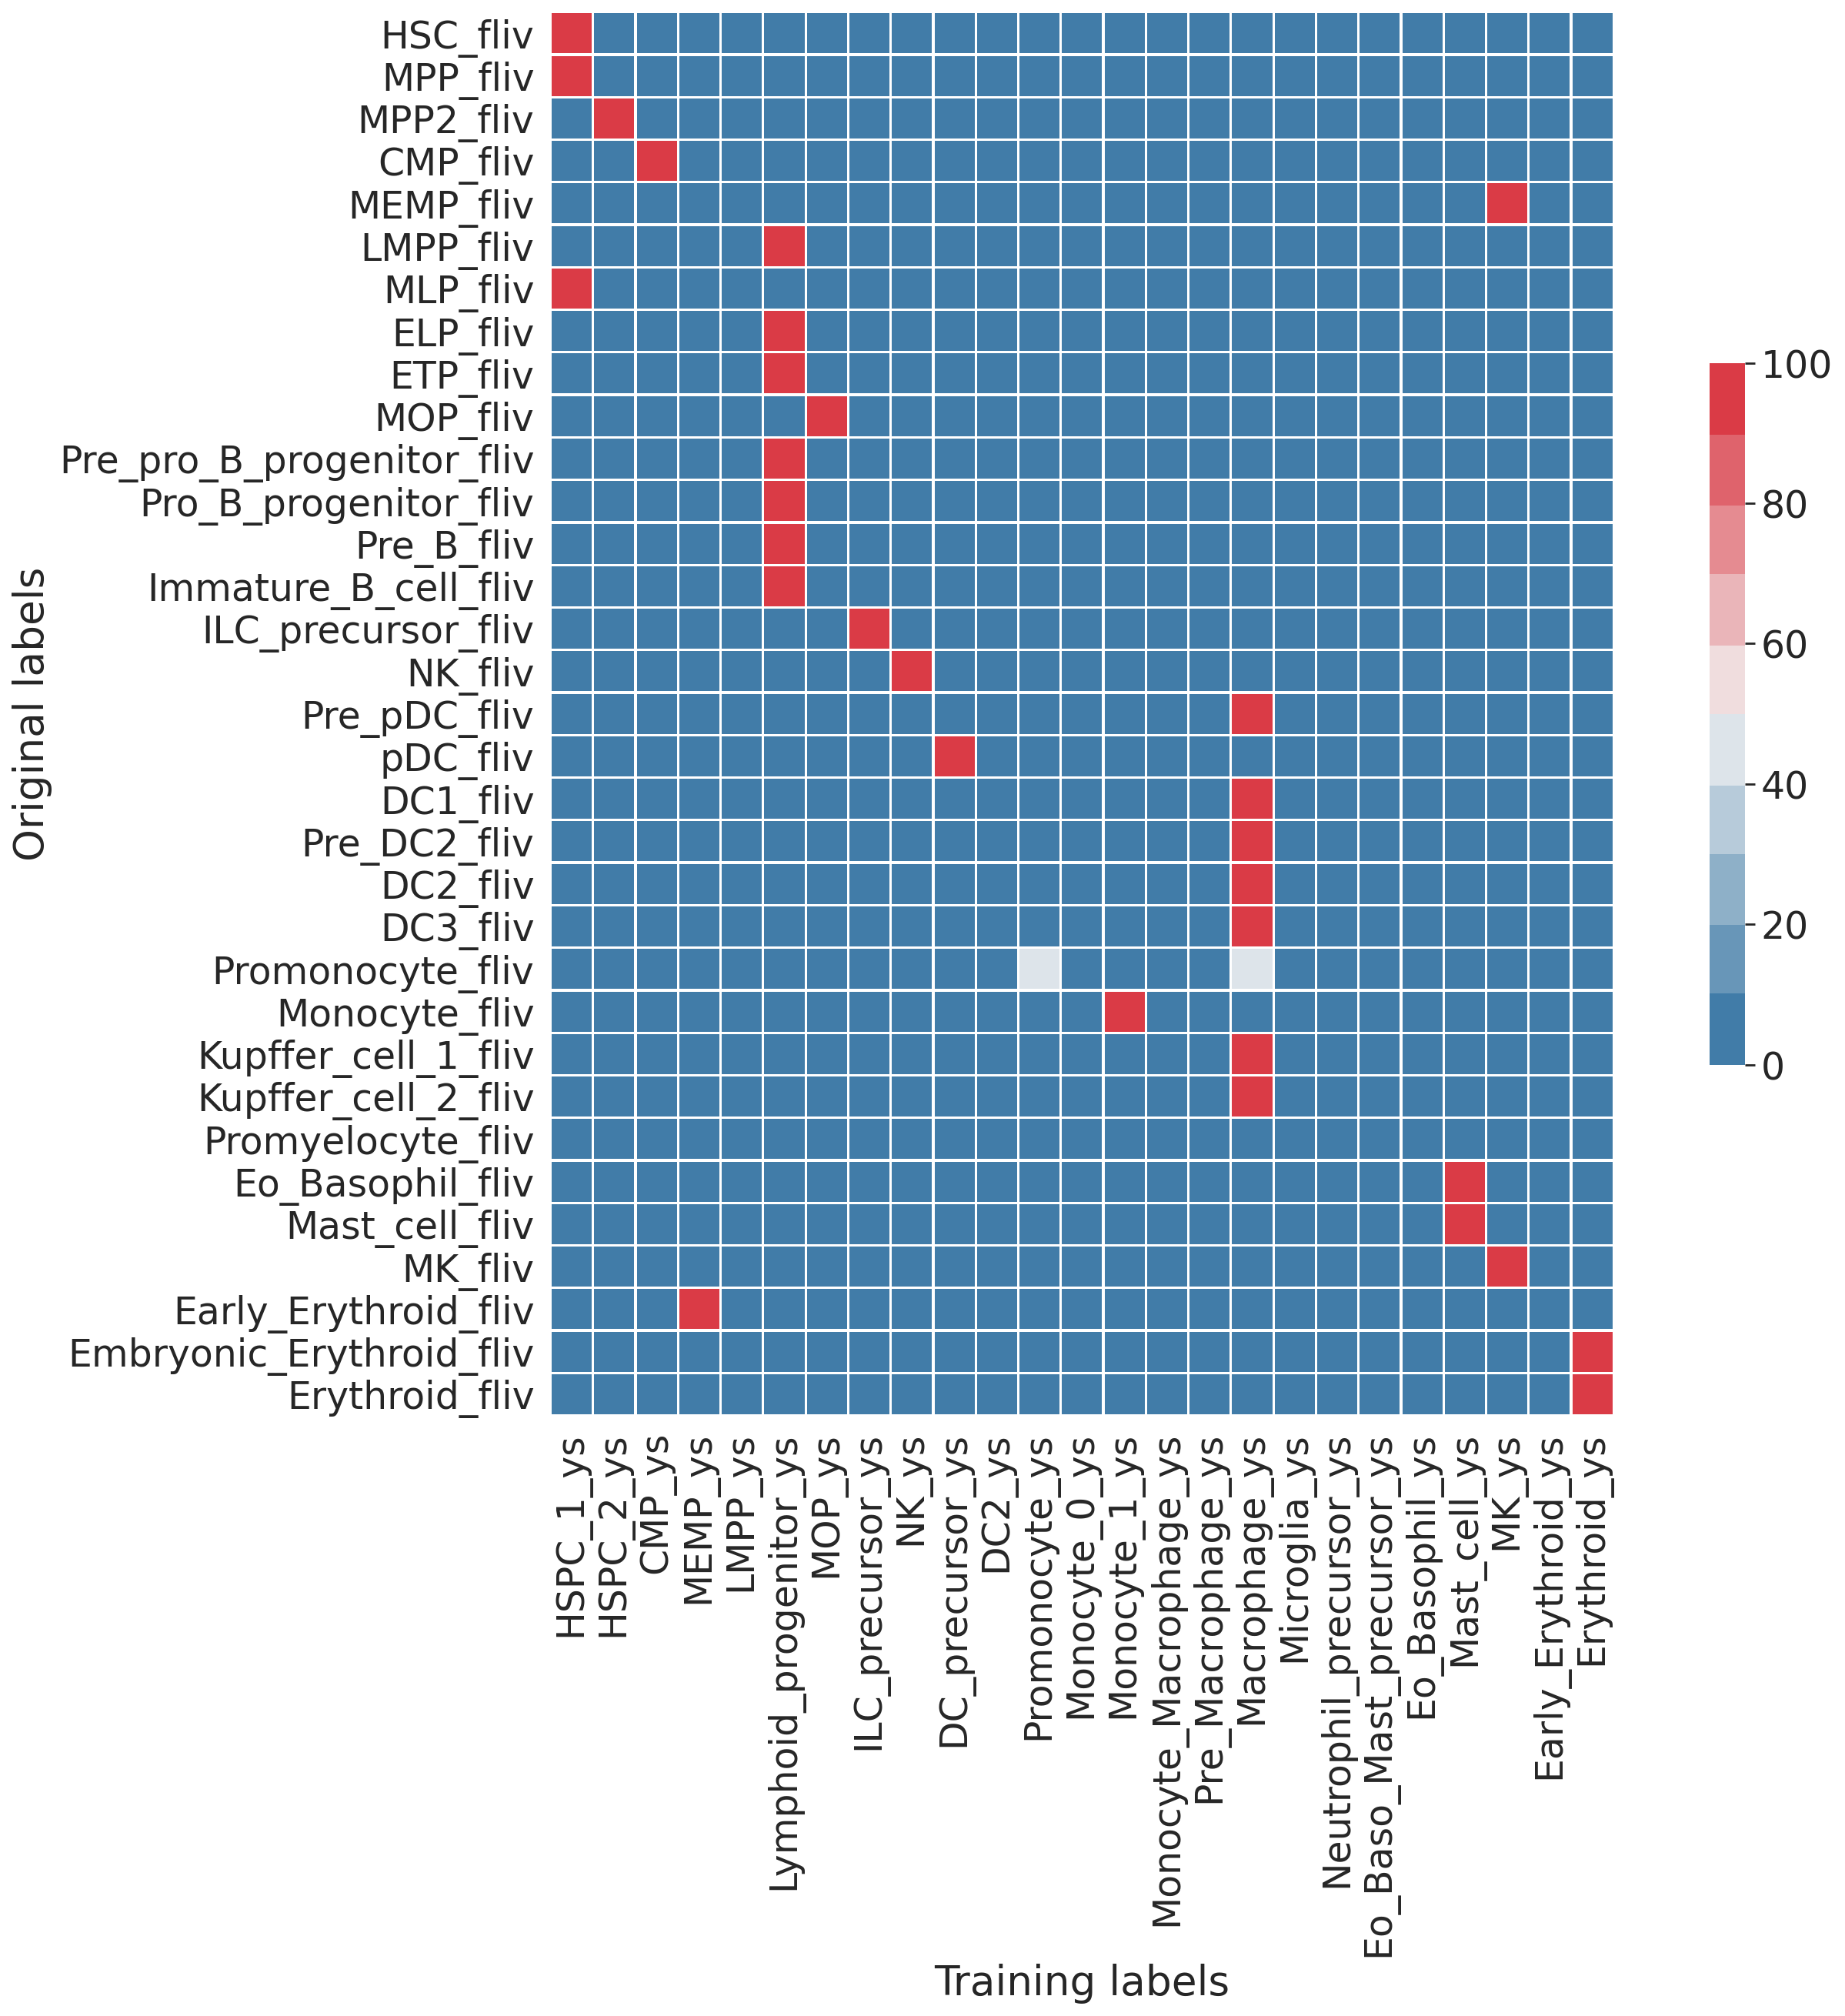

In [86]:
crs_tbl = crs_tbl[sort_ys]
crs_tbl = crs_tbl.T[sort_fliv]
crs_tbl = crs_tbl.T

# Plot_df_heatmap(crs_tbl, cmap='coolwarm', rotation=90, vmin=20, vmax=70)
pal = sns.diverging_palette(240, 10, n=10)
plt.figure(figsize=(20,15))
sns.set(font_scale=2)
g = sns.heatmap(crs_tbl, cmap=pal,  annot=False,vmin=0, vmax=100, linewidths=1, center=50, square=True, cbar_kws={"shrink": 0.5})
plt.ylabel("Original labels")
plt.xlabel("Training labels")

plt.savefig('./ver9_220401_lr_model_qc_means_clusters.pdf',dpi=300)

In [87]:
pred_out.to_csv('./040422_LR_qc_X_pred_out.csv')
crs_tbl.to_csv('./040422_crs_tbl_qc_X_pred_out.csv')

In [88]:
pred_out

,predicted,orig_labels,AEC_ys,CMP_ys,DC2_ys,DC_precursor_ys,Early_Erythroid_ys,Endoderm_ys,Eo_Baso_Mast_precursor_ys,Eo_Basophil_ys,...,Monocyte_Macrophage_ys,NK_ys,Neutrophil_precursor_ys,Pre_Macrophage_ys,Prolif_AEC_ys,Prolif_Sinusoidal_EC_ys,Promonocyte_ys,Sinusoidal_EC_ys,Smooth_Muscle_ys,VWF_EC_ys
F61_Liver_CD45+_FCAImmP7862084_AAACCTGAGCTACCGC,Macrophage_ys,Kupffer_cell_1_fliv,1.424746e-07,1.822155e-07,4.272392e-08,1.648200e-07,1.308840e-07,2.958961e-07,1.863724e-07,1.285935e-05,...,1.204240e-04,4.794049e-07,6.850308e-07,1.676553e-04,7.164906e-08,3.661578e-08,2.101277e-05,6.340211e-06,3.442500e-10,8.384014e-07
F61_Liver_CD45+_FCAImmP7862084_AAACCTGAGTCCGGTC,Macrophage_ys,Kupffer_cell_2_fliv,1.103366e-06,5.892778e-07,1.086131e-05,6.080299e-05,1.460548e-06,3.506694e-08,2.105025e-06,7.055924e-06,...,1.222031e-03,2.893543e-06,2.151564e-06,4.291669e-05,5.228467e-08,1.091531e-09,2.800087e-04,4.929163e-07,6.279848e-08,3.670901e-07
F61_Liver_CD45+_FCAImmP7862084_AAACCTGCAAGTAATG,Endoderm_ys,Hepatocyte_fliv,4.673709e-08,7.094447e-06,1.496293e-05,3.398126e-07,2.635232e-06,9.993739e-01,5.284119e-07,1.462453e-06,...,7.691646e-07,6.450060e-07,5.932675e-07,2.817428e-07,5.290475e-06,9.284389e-06,9.676941e-06,8.564578e-09,3.532744e-11,3.579099e-08
F61_Liver_CD45+_FCAImmP7862084_AAACCTGCACCACGTG,Macrophage_ys,Kupffer_cell_1_fliv,2.576912e-10,1.680474e-08,3.709493e-07,4.001012e-09,2.938913e-08,9.125395e-10,2.625245e-08,7.446134e-08,...,7.584648e-07,3.160912e-08,8.804514e-09,1.244686e-05,1.058840e-07,2.020308e-07,4.789034e-06,1.213667e-08,2.224817e-14,8.953486e-10
F61_Liver_CD45+_FCAImmP7862084_AAACCTGCACCATCCT,Macrophage_ys,Kupffer_cell_1_fliv,3.083873e-06,3.308035e-07,7.265049e-08,2.208714e-06,3.055924e-07,1.476239e-06,6.613291e-07,1.618802e-06,...,1.540908e-04,1.251216e-06,9.098331e-07,1.132356e-04,1.132302e-06,6.362369e-06,8.046936e-05,2.114019e-03,3.108066e-10,3.231458e-06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
F32_Liver_CD45-_FCAImmP7316895_TTTGGTTTCACATGCA,Endoderm_ys,Hepatocyte_fliv,1.131509e-07,3.743317e-07,5.825261e-08,1.144515e-07,2.870190e-06,9.998462e-01,1.654103e-07,6.928456e-08,...,2.472950e-07,7.138266e-08,5.604460e-08,3.439399e-08,5.482627e-08,7.313077e-09,2.508944e-07,2.667395e-08,4.293662e-09,3.233538e-08
F32_Liver_CD45-_FCAImmP7316895_TTTGGTTTCTCTGTCG,Erythroid_ys,Erythroid_fliv,1.472089e-12,4.185141e-10,4.226198e-09,8.822387e-11,1.474224e-05,3.011942e-08,2.920117e-10,1.044449e-09,...,1.456609e-10,4.709944e-10,3.048361e-10,6.214965e-11,1.244569e-09,7.121912e-09,5.341058e-10,7.694079e-12,1.285315e-14,1.506717e-12
F32_Liver_CD45-_FCAImmP7316895_TTTGTCAAGGTGCACA,MEMP_ys,Early_Erythroid_fliv,1.166167e-05,2.631239e-03,5.919693e-04,6.795422e-05,3.131386e-02,2.380752e-03,8.767858e-03,1.049650e-03,...,5.678920e-05,2.187769e-04,1.989256e-04,1.108471e-04,6.381213e-05,3.698307e-06,1.618550e-04,1.553472e-06,4.525747e-05,3.493514e-05
F32_Liver_CD45-_FCAImmP7316895_TTTGTCAAGTACGCCC,Endoderm_ys,Hepatocyte_fliv,5.622615e-08,8.001630e-07,2.465271e-07,2.406648e-07,1.272080e-05,9.993058e-01,2.220947e-07,3.078526e-07,...,2.471236e-07,1.579061e-07,8.031090e-08,3.833924e-08,5.959668e-08,1.816186e-08,7.012712e-07,9.232716e-08,2.384741e-08,2.393404e-08


In [186]:
np.median(model_mean_probs[i])

4.486378e-05

In [185]:
np.std(model_mean_probs[i])

0.17373756

In [164]:
# x = 'predicted'
# y = common_cat

# y_attr = adata.obs[y]
# x_attr = adata.obs[x]
# crs = pd.crosstab(x_attr, y_attr)
# crs_tbl = crs
# for col in crs_tbl :
#     crs_tbl[col] = crs_tbl[col].div(crs_tbl[col].sum(axis=0)).multiply(100).round(2)
# # Sort df columns by rows
# index_order = list(crs_tbl.max(axis=1).sort_values(ascending=False).index)
# col_order = list(crs_tbl.max(axis=0).sort_values(ascending=False).index)
# crs_tbl = crs_tbl.loc[index_order]
# crs_tbl = crs_tbl[col_order]
# # Plot_df_heatmap(crs_tbl, cmap='coolwarm', rotation=90, vmin=20, vmax=70)
# pal = sns.diverging_palette(240, 10, n=10)
# plt.figure(figsize=(20,15))
# sns.set(font_scale=0.8)
# g = sns.heatmap(crs_tbl, cmap=pal, vmin=0, vmax=100, linewidths=1, center=50, square=True, cbar_kws={"shrink": 0.5})
# plt.xlabel("Original labels")
# plt.ylabel("Predicted labels")
# plt.savefig(save_path + "/LR_predictions.pdf")
# crs_tbl.to_csv(save_path + "/pre-freq_LR_predictions_supp_table.csv")

# Read new, reorder and plot

In [27]:
sort_fliv = ["HSC_fliv",
"MPP_fliv",
"MPP2_fliv",
"CMP_fliv",
"MEMP_fliv",
"LMPP_fliv",
"MLP_fliv",
"ELP_fliv",
"ETP_fliv",
"MOP_fliv",
"Pre_pro_B_progenitor_fliv",
"Pro_B_progenitor_fliv",
"Pre_B_fliv",
"Immature_B_cell_fliv",
"Pre_ILC_precursor_fliv",
"ILC_precursor_fliv",
"NK_fliv",
"Pre_pDC_fliv",
"pDC_fliv",
"DC1_fliv",
"Pre_DC2_fliv",
"DC2_fliv",
"DC3_fliv",
"Promonocyte_fliv",
"Monocyte_fliv",
"Kupffer_cell_1_fliv",
"Kupffer_cell_2_fliv",
"Promyelocyte_fliv",
"Eo_Basophil_fliv",
"Mast_cell_fliv",
"MK_fliv",
"Early_Erythroid_fliv",
"Embryonic_Erythroid_fliv",
"Erythroid_fliv",]

In [28]:
sort_ys = ["HSPC_1_ys",
"HSPC_2_ys",
"CMP_ys",
"MEMP_ys",
"LMPP_ys",
"Lymphoid_progenitor_ys",
"MOP_ys",
"ILC_precursor_ys",
"NK_ys",
"DC_precursor_ys",
"DC2_ys",
"Promonocyte_ys",
'Monocyte_0',
 'Monocyte_ys_1',
"Monocyte_Macrophage_ys",
"Pre_Macrophage_ys",
"Macrophage_ys",
"Microglia_ys",
"Neutrophil_precursor_ys",
"Eo_Baso_Mast_precursor_ys",
"Eo_Basophil_ys",
"Mast_cell_ys",
"MK_ys",
"Early_Erythroid_ys",
"Erythroid_ys",]

In [29]:
crs_tbl = crs_tbl.T[sort_ys]
crs_tbl = crs_tbl.T[sort_fliv]


KeyError: "['Monocyte_0'] not in index"

In [ ]:
pal = sns.diverging_palette(240, 10, n=10)
plt.figure(figsize=(20,15))
sns.set(font_scale=0.8)
g = sns.heatmap(crs_tbl, cmap=pal, vmin=0, vmax=100, linewidths=1, center=50, square=True, cbar_kws={"shrink": 0.5})
plt.xlabel("Original labels")
plt.ylabel("Predicted labels")
plt.savefig(save_path + "/train_ys_cell_labels_fliv_ys_broad_LR_predictions.pdf")
crs_tbl.to_csv(save_path + "/train_ys_cell_labels_ys_broad_pre-freq_LR_predictions_supp_table.csv")

In [59]:
crs_tbl = pd.read_csv('/nfs/team205/ig7/work_backups/backup_210306/projects/YS/YS_090321_notebooks/YS_Reprocess_250721_updates/LR_YS_LIV/FIG_2C/train_ys_cell_labels_ys_broad_pre-freq_LR_predictions_supp_table.csv',header=0,index_col=0)
crs_tbl

,HSC_fliv,MPP_fliv,MPP2_fliv,CMP_fliv,MEMP_fliv,LMPP_fliv,MLP_fliv,ELP_fliv,ETP_fliv,MOP_fliv,...,Monocyte_fliv,Kupffer_cell_1_fliv,Kupffer_cell_2_fliv,Promyelocyte_fliv,Eo_Basophil_fliv,Mast_cell_fliv,MK_fliv,Early_Erythroid_fliv,Embryonic_Erythroid_fliv,Erythroid_fliv
predicted,,,,,,,,,,,,,,,,,,,,,
HSPC_1_ys,96.60,58.02,43.04,11.98,0.30,12.82,81.45,4.23,19.83,0.00,...,0.17,0.00,0.00,12.08,2.81,0.00,0.00,0.05,0.60,0.02
HSPC_2_ys,0.97,35.13,41.27,37.39,10.65,29.06,1.61,14.08,0.00,0.39,...,0.00,0.00,0.00,4.15,2.81,0.00,0.13,0.65,1.19,0.00
CMP_ys,0.00,0.28,0.00,41.92,0.00,0.00,0.00,0.00,0.00,1.18,...,0.00,0.00,0.00,19.25,0.00,0.00,0.00,0.05,0.00,0.00
MEMP_ys,0.24,0.00,2.03,0.91,73.83,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.38,6.88,2.09,0.00,32.59,0.60,0.00
LMPP_ys,0.00,3.24,0.00,1.27,0.00,43.59,3.23,10.99,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
Lymphoid_progenitor_ys,0.00,0.09,0.00,0.18,0.00,10.26,12.63,65.35,71.90,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
MOP_ys,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.28,0.00,43.14,...,1.98,0.00,0.00,22.64,0.00,0.00,0.00,0.00,0.00,0.02
ILC_precursor_ys,0.00,0.09,0.00,0.00,0.00,0.85,0.00,0.28,1.10,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
NK_ys,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,3.86,0.00,...,0.33,0.00,0.00,0.00,0.00,0.52,0.07,0.02,0.00,0.00


In [60]:
save_path = '/nfs/team205/ig7/work_backups/backup_210306/projects/YS/YS_090321_notebooks/YS_Reprocess_250721_updates/LR_YS_LIV/'

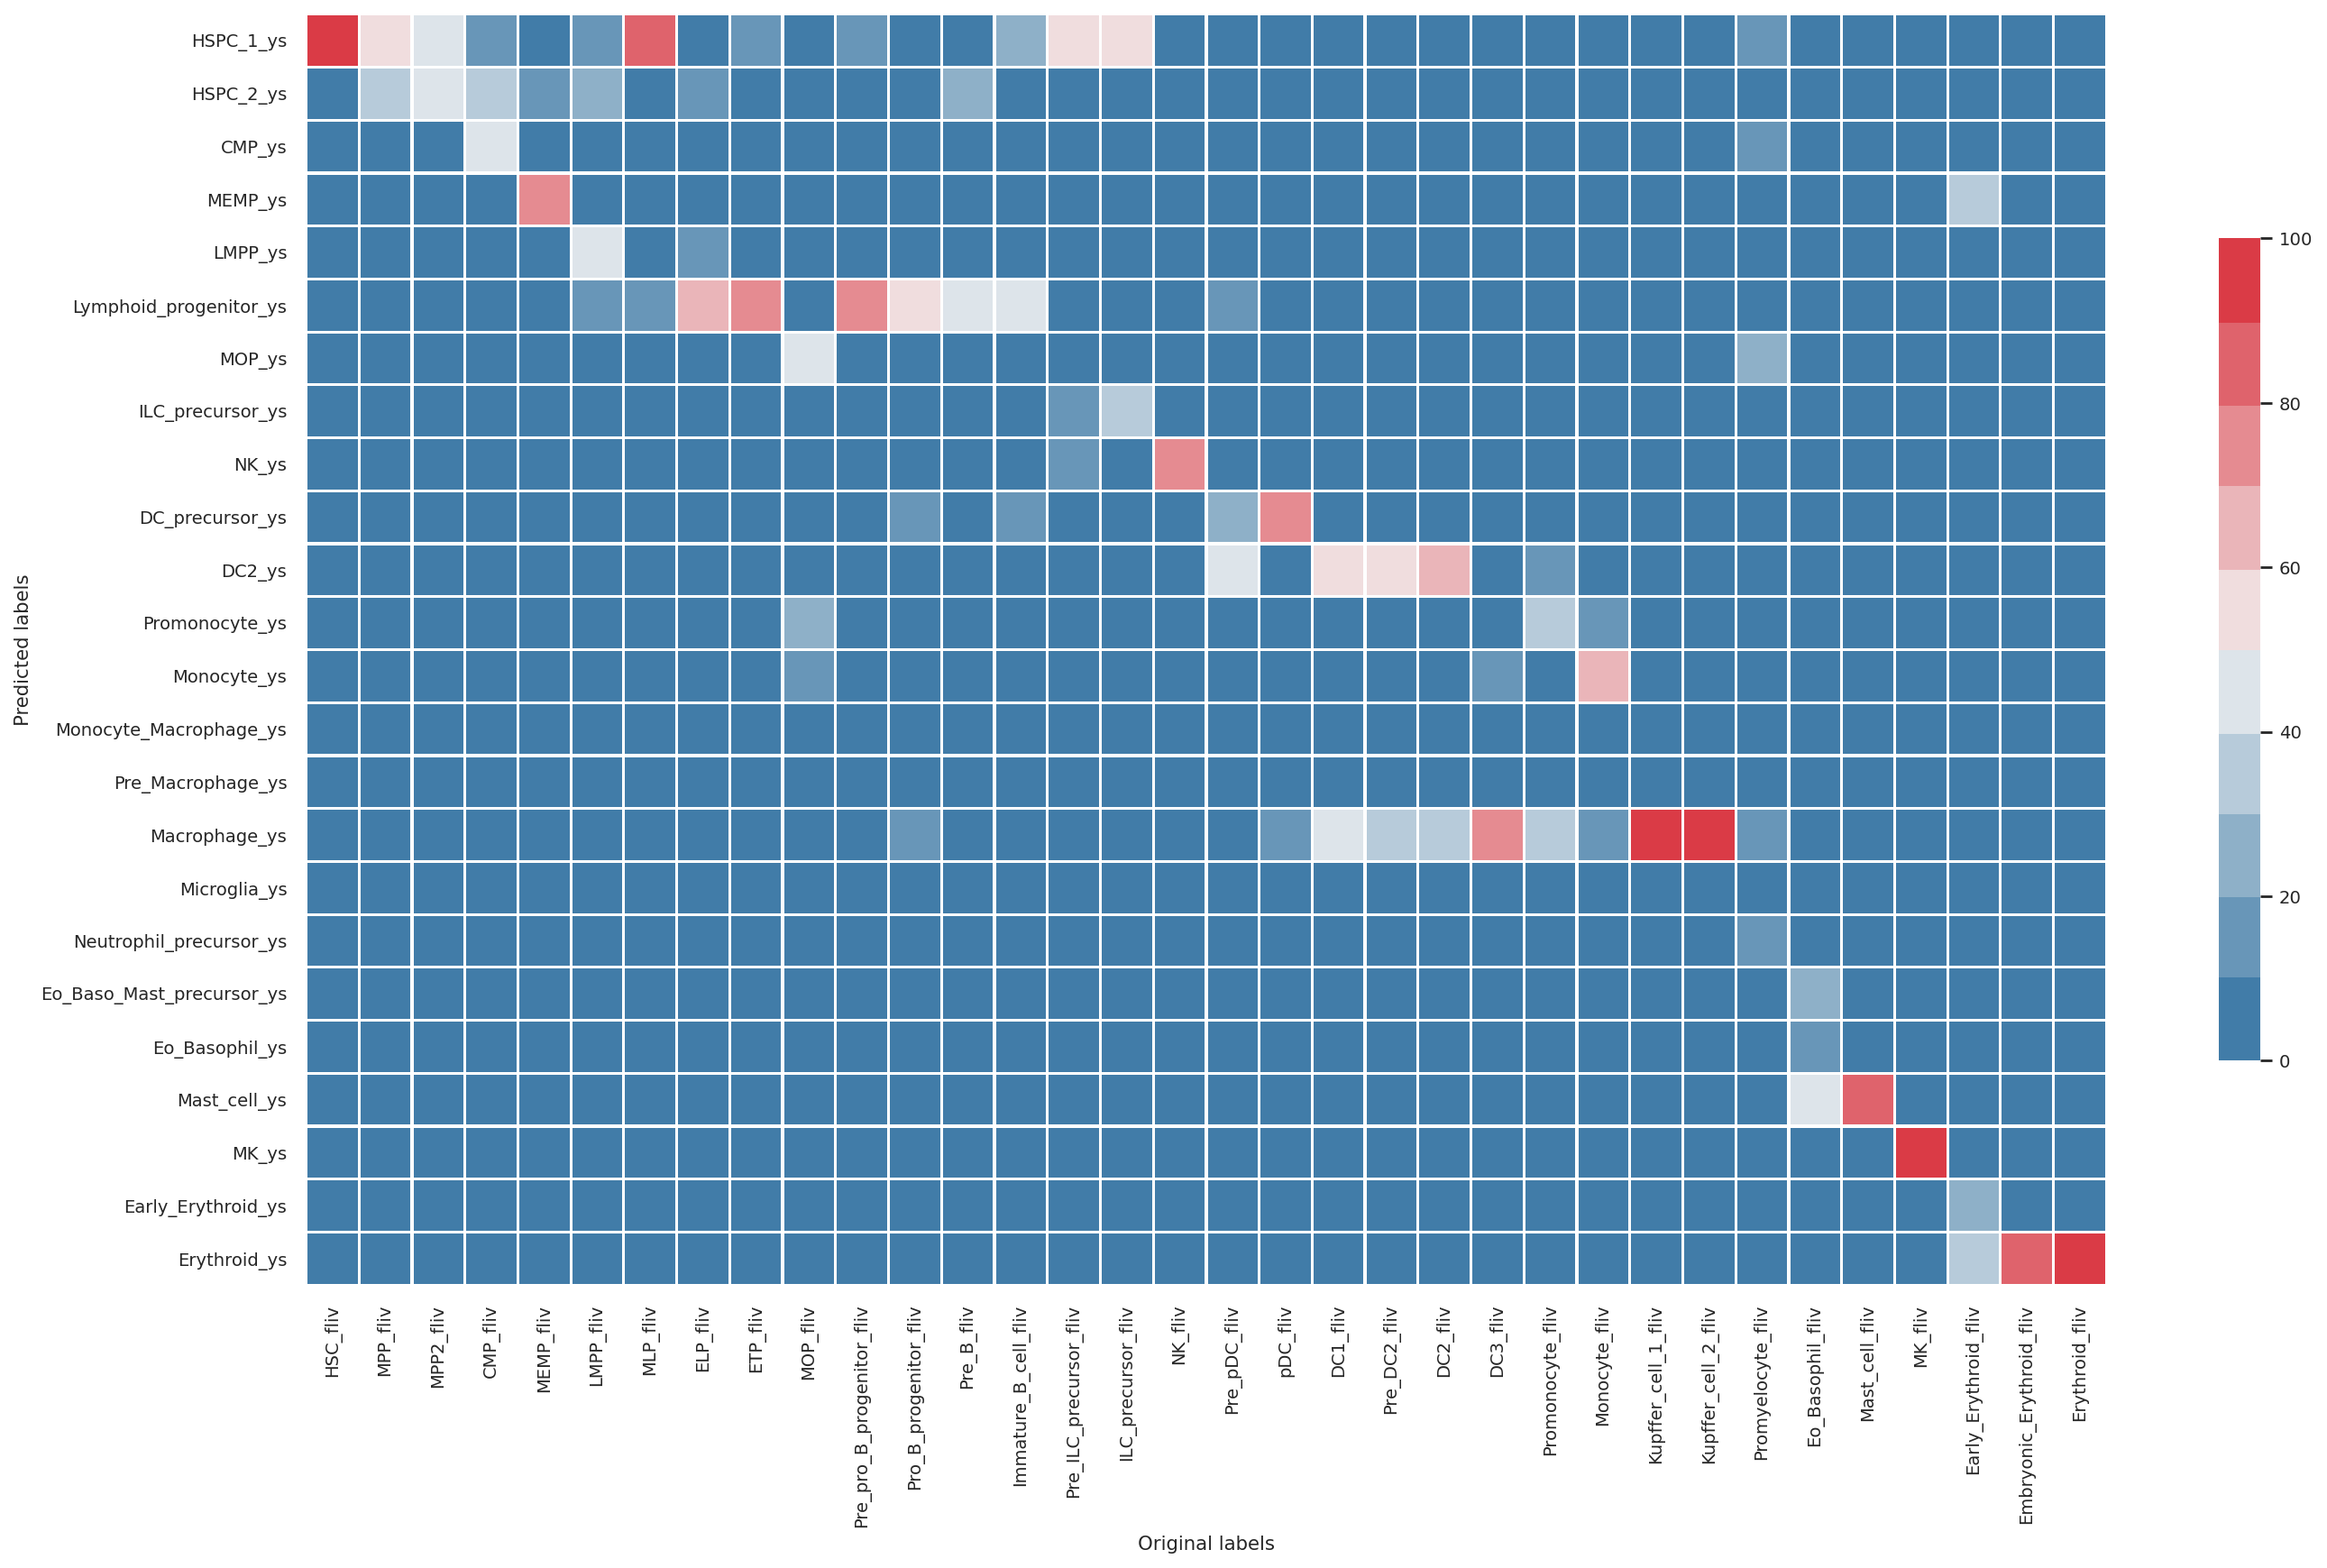

In [61]:
pal = sns.diverging_palette(240, 10, n=10)
plt.figure(figsize=(20,15))
sns.set(font_scale=0.8)
g = sns.heatmap(crs_tbl, cmap=pal, vmin=0, vmax=100, linewidths=1, center=50, square=True, cbar_kws={"shrink": 0.5})
plt.xlabel("Original labels")
plt.ylabel("Predicted labels")
plt.savefig(save_path + "/LR_predictions.pdf")
crs_tbl.to_csv(save_path + "/pre-freq_LR_predictions_supp_table.csv")

In [ ]:
crs_tbl = pd.read_csv('/nfs/team205/ig7/work_backups/backup_210306/projects/YS/YS_090321_notebooks/YS_Reprocess_250721_updates/endo_LR_BM/including_endo_lr/no_endo_pre-freq_LR_predictions_supp_table.csv',index_col=0)
pal = sns.diverging_palette(240, 10, n=10)
plt.figure(figsize=(20,15))
sns.set(font_scale=0.8)
g = sns.heatmap(crs_tbl, cmap=pal, vmin=0, vmax=100, linewidths=1, center=50, square=True, cbar_kws={"shrink": 0.5})
plt.xlabel("Original labels")
plt.ylabel("Predicted labels")
plt.savefig(save_path + "/LR_predictions.pdf")
crs_tbl.to_csv(save_path + "/pre-freq_LR_predictions_supp_table.csv")

In [13]:
group1 = (adata.obs[common_cat][adata.obs[common_cat].str.contains(Data1_group)]).unique()

### Proportion of cells per group

In [ ]:
prop = adata.obs.groupby('predicted').count()
prop['percentage'] = (prop.iloc[:,6]/prop.iloc[:,6].sum())*100
prop = prop['percentage']
prop.to_csv(save_path + "/pre-freq_predicted_prop.csv")
prop

## Modules to compute Leiden-LR Consensus

## Clustering 

In [ ]:
# Optional clustering 
res = 5
key_add = 'leiden'
adata.obs[key_add] = "nan"
sc.tl.leiden(adata, resolution= res, key_added= key_add, random_state=26, n_iterations=-1)

In [ ]:
cluster_prediction = "clus_prediction"
clusters_reassign = "leiden"
lr_predicted_col = 'predicted'

In [ ]:
adata.obs[cluster_prediction] = adata.obs.index
for z in adata.obs[clusters_reassign].unique():
    df = adata.obs
    df = df[(df[clusters_reassign].isin([z]))]
    df_count = pd.DataFrame(df[lr_predicted_col].value_counts())
    freq_arranged = df_count.index
    cat = freq_arranged[0]
    df.loc[:,cluster_prediction] = cat
    adata.obs.loc[adata.obs[clusters_reassign] == z, [cluster_prediction]] = cat

### Heatmap showing cells in predicted clusters

In [ ]:
# Create a concat col for old + predicted annots
adata.obs['annot_clus_prediction_concat'] = adata.obs[cat1].astype(str) + "_" + adata.obs['clus_prediction'].astype(str)

x='clus_prediction'
y = common_cat

y_attr = adata.obs[y]
x_attr = adata.obs[x]
crs = pd.crosstab(x_attr, y_attr)
crs_tbl = crs
for col in crs_tbl :
    crs_tbl[col] = crs_tbl[col].div(crs_tbl[col].sum(axis=0)).multiply(100).round(2)

#plot_df_heatmap(crs_tbl, cmap='coolwarm', rotation=90, vmin=20, vmax=70)
pal = sns.diverging_palette(240, 10, n=10)
plt.figure(figsize=(20,10))
sns.set(font_scale=0.8)
g = sns.heatmap(crs_tbl, cmap=pal, vmin=0, vmax=100, linewidths=1, center=50, square=True, cbar_kws={"shrink": 0.3})
plt.xlabel("Original labels")
plt.ylabel("Predicted labels")
plt.savefig(save_path + "/LR_predictions_consensus.pdf")
crs_tbl.to_csv(save_path + "/post-freq_LR_predictions_consensus_supp_table.csv")

In [ ]:
prop = adata.obs.groupby('clus_prediction').count()
prop['percentage'] = prop.iloc[:,6]/prop.iloc[:,6].sum()
prop = prop['percentage']
prop.to_csv(save_path + "/post-freq_predicted_leiden_consensus_prop.csv")
prop

In [ ]:
# Generate a umap to view your current data
sc.tl.umap(adata)

def generate_colors(col_required):
    import random
    number_of_colors = col_required
    color = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])
                 for i in range(number_of_colors)]
    return list(color)

col = generate_colors(len(adata.obs["predicted"].unique()))
sc.pl.umap(adata, color='predicted', palette = col, save = "prediction_umap.pdf")

col = generate_colors(len(adata.obs["clus_prediction"].unique()))
sc.pl.umap(adata, color='clus_prediction', palette = col, save = "clus_prediction_umap.pdf")

In [ ]:
# Are any celltypes removed between prediction and cluster consensus step?
prediction_set = list(adata.obs['predicted'].unique())
clust_prediction_set = list(adata.obs['clus_prediction'].unique())
non_intersect = set(prediction_set) ^ set(clust_prediction_set)
non_intersect = non_intersect.intersection(prediction_set)

if (len(non_intersect)>0):
    print(str(len(non_intersect)) + " labels were omitted during the consensus redistribution step! Please check if these labels are expected to be significantly available in the prediction dataset! Missin labels are::" )
    print("################################")
    print(non_intersect)
    
    # plot umap coloring only labels that were lost in consensus step
    sc.pl.umap(adata,color="predicted",groups=non_intersect, save = "freq_redistribution_omitted_labels_umap.pdf")
else: print("No labels were omitted!")

In [ ]:

# calculate Rand and MI
rand = sklearn.metrics.adjusted_rand_score(list(adata.obs['predicted']), list(adata.obs['clus_prediction']))
mi = sklearn.metrics.adjusted_mutual_info_score(list(adata.obs['predicted']), list(adata.obs['clus_prediction']), 
                                                average_method='arithmetic')

# test concordance between the predicted labels by cell and the consensus clusters
if ((rand<0.8) | (mi<0.8)):
    print("Your concordance between predicted and consensus leiden labels are weak, please attempt reclustering at higher resolution and running consensus again")
    print("Adj Rand extimate = " + str(rand) + "  " + "Mutual Information score=" + str(mi))
else: 
    print("success")
    print("You have achieved good consensus between predicted labels and consensus leiden labels")
    print("Adj Rand extimate = " + str(rand) + "  " + "Mutual Information score=" + str(mi))

In [ ]:
# Note: if low could be due to removed celltypes or may be expected if the cells are quite different such as from different organs, 
# plot cells to check groups and see if group together nicely or all over 

# Save dataframe with new labels 

In [ ]:
df = adata.obs[["predicted", "leiden", "clus_prediction"]]
df = df.rename(columns={"predicted": "pre_freq_clus_prediction", "clus_prediction": "post_freq_clus_prediction"})
df.to_csv(save_path + "/final_lr_metadata_for_adata2.csv")
df